In [95]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from multiprocessing.dummy import Pool as ThreadPool

# Web Scraping

In [297]:
urls = ['https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=0',
        'https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=100',
        'https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=200',
       'https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=300',
       'https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=400',
       'https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=500',
       'https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=600',
       'https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=700',
       'https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=800',
       'https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=900',
       'https://www.autotrader.com/cars-for-sale/Chicago+IL-60611?searchRadius=50&zip=60611&marketExtension=true&sortBy=relevance&numRecords=100&firstRecord=1000']

In [294]:
def get_used_car_values(url):
    driver = webdriver.Chrome("/usr/local/bin/chromedriver")
    driver.get(url)
    used_car_soup = BeautifulSoup(driver.page_source)
    driver.quit()
    
    used_car_summary = used_car_soup.find_all('div', attrs={'class': 'positioned-overlay-base'})
    car_values = []
    for link in used_car_summary:
        info = link.find('h2', attrs={'class' : 'text-bold text-size-400 text-size-sm-500 link-unstyled', 'data-cmp': "subheading"})
        if link.find('h2', attrs={'data-cmp': "subheading"}) != None:
            info = [
                link.find('h2', attrs={'data-cmp': "subheading"}).text,
                link.find('div', attrs={'data-cmp': 'pricing'}).text,
                link.find('div', attrs={'class': 'item-card-specifications margin-top-4 text-subdued-lighter margin-bottom-3'}).find().text
            ]
            for attr in link.find('div', attrs={'class': 'item-card-specifications margin-top-4 text-subdued-lighter margin-bottom-3'}).find_all('li', attrs={'class': ''}):
                info.append(attr.text)
            car_values.append(info)
    return car_values

In [298]:
car_values = []
pool = ThreadPool(3)
car_values = pool.map(get_used_car_values, urls)
pool.close()
pool.join()

In [299]:

def split_car_elements(car_array):
    new_car_array = []
    
    #split first element
    car_type = car_array[0].split(' ')
    for i in range(0,4):
        new_car_array.append(car_type[i])
    new_car_array.append(" ".join(car_type[4:]))
    
    #append rest of elements
    new_car_array = new_car_array + car_array[1:]
    
    return new_car_array
    
new_car_values = []
for i in range(0,len(car_values)):
    new_car_values += list(map(lambda car_array: split_car_elements(car_array), car_values[i]))

print(len(new_car_values))

1104


In [300]:
for car_value in new_car_values:
    if len(car_value) != 11:
        new_car_values.remove(car_value)
print(len(new_car_values))

1011


In [301]:
used_car_values_df = pd.DataFrame(new_car_values, columns=['Status', 'Year', 'Make', 'Model', 'Trim Level', 'Cost', 'Miles', 'Color', 'MPG', 'Drive Type', 'Engine'])

In [302]:
with open('used_cars.pickle', 'wb') as to_write:
    pickle.dump(used_car_values_df, to_write)

# Data Cleaning and Wrangling

In [96]:
with open('used_cars.pickle','rb') as read_file:
    used_car_values_df = pickle.load(read_file)

In [97]:
used_car_values_df.head(5)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,MPG,Drive Type,Engine
0,Certified,2017,Chrysler,300,S AWD,"22,500","29,946 miles",Color: Gray,MPG: 18 City / 27 Highway,Drive Type: All wheel drive,Engine: 6-Cylinder
1,Used,2018,Toyota,Corolla,LE,"12,907","49,465 miles",Color: Gray,MPG: 28 City / 36 Highway,Drive Type: 2 wheel drive - front,Engine: 4-Cylinder
2,Used,2018,Lexus,NX,300 AWD,"35,972","9,188 miles",Color: Silver,MPG: 22 City / 28 Highway,Drive Type: All wheel drive,Engine: 4-Cylinder Turbo
3,Used,2017,Chevrolet,Cruze,LT Sedan,"13,150","16,748 miles",Color: White,MPG: 30 City / 40 Highway,Drive Type: 2 wheel drive - front,Engine: 4-Cylinder Turbo
4,Used,2014,Acura,RDX,AWD w/ Technology Package,"18,500","47,688 miles",Color: Silver,MPG: 19 City / 27 Highway,Drive Type: All wheel drive,Engine: 6-Cylinder


## Adjust Land Rover Data

In [98]:
used_car_values_df['Make'].loc[used_car_values_df['Make'] == 'Land'] = 'Land Rover'
for i, row in used_car_values_df.iterrows():
    if row['Make'] == 'Land Rover':
        if 'Discovery' in row['Trim Level']:
            row['Model'] = 'Discovery'
            row['Trim Level'] = row['Trim Level'].replace('Discovery ', '')
        else:
            row['Model'] = 'Range Rover'
            row['Trim Level'] = row['Trim Level'].replace('Range Rover ', '')

used_car_values_df.loc[used_car_values_df['Make'] == 'Land Rover']

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,MPG,Drive Type,Engine
91,Certified,2015,Land Rover,Discovery,Sport HSE,"28,988","23,919 miles",Color: White,MPG: 20 City / 26 Highway,Drive Type: All wheel drive,Engine: 4-Cylinder Turbo
94,Used,2014,Land Rover,Range Rover,HSE,"48,988","25,836 miles",Color: Black,MPG: 17 City / 23 Highway,Drive Type: 4 wheel drive,Engine: 6-Cylinder Supercharged
134,Used,2016,Land Rover,Range Rover,Supercharged,"62,000","22,581 miles",Color: Black,MPG: 14 City / 19 Highway,Drive Type: 4 wheel drive,Engine: 8-Cylinder Supercharged
167,Used,2015,Land Rover,Range Rover,Sport SVR,"69,888","37,781 miles",Color: Black,MPG: 14 City / 19 Highway,Drive Type: 4 wheel drive,Engine: 8-Cylinder Supercharged
232,Certified,2019,Land Rover,Discovery,Sport HSE,"42,939","3,214 miles",Color: Gray,MPG: 21 City / 25 Highway,Drive Type: All wheel drive,Engine: 4-Cylinder Turbo
370,Used,2016,Land Rover,Discovery,Sport HSE,"24,700","53,601 miles",Color: Gray,MPG: 20 City / 26 Highway,Drive Type: All wheel drive,Engine: 4-Cylinder Turbo
452,Certified,2016,Land Rover,Discovery,Sport HSE,"33,995","12,788 miles",Color: Gray,MPG: 20 City / 26 Highway,Drive Type: All wheel drive,Engine: 4-Cylinder Turbo
455,Certified,2017,Land Rover,Range Rover,Evoque SE Dynamic,"39,988","20,537 miles",Color: White,MPG: 20 City / 28 Highway,Drive Type: All wheel drive,Engine: 4-Cylinder Turbo
496,Used,2016,Land Rover,Range Rover,Sport HSE,"43,980","33,870 miles",Color: Black,MPG: 17 City / 23 Highway,Drive Type: 4 wheel drive,Engine: 6-Cylinder Supercharged
565,Used,2015,Land Rover,Range Rover,Sport Supercharged,"45,000","49,477 miles",Color: White,MPG: 14 City / 19 Highway,Drive Type: 4 wheel drive,Engine: 8-Cylinder Supercharged


## Remove Null Values

In [99]:
used_car_values_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 11 columns):
Status        1011 non-null object
Year          1011 non-null object
Make          1011 non-null object
Model         1011 non-null object
Trim Level    1011 non-null object
Cost          1011 non-null object
Miles         1011 non-null object
Color         1011 non-null object
MPG           1011 non-null object
Drive Type    1010 non-null object
Engine        990 non-null object
dtypes: object(11)
memory usage: 87.0+ KB


Engine has fewest values. Why is that?

In [100]:
used_car_values_df.describe()

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,MPG,Drive Type,Engine
count,1011,1011,1011,1011,1011,1011,1011,1011,1011,1010,990
unique,2,14,35,203,362,805,990,17,148,13,12
top,Used,2016,Nissan,Rogue,S,"15,000",10 miles,Color: Black,MPG: 19 City / 26 Highway,Drive Type: All wheel drive,Engine: 4-Cylinder
freq,707,349,88,34,36,11,8,251,46,451,309


In [101]:
used_car_values_df[used_car_values_df.isnull().any(axis=1)]

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,MPG,Drive Type,Engine
133,Used,2016,Dodge,Challenger,SRT Hellcat,"52,000","7,892 miles",Color: White,Drive Type: 2 wheel drive - rear,Engine: 8-Cylinder Supercharged,None
240,Used,2010,Pontiac,Vibe,,"5,993","83,786 miles",Color: Blue,Drive Type: 2 wheel drive - front,Engine: 4-Cylinder,None
287,Certified,2018,Jeep,Renegade,4WD Latitude,"20,994","1,149 miles",Drive Type: 4 wheel drive - front,Engine: 4-Cylinder,None,None
302,Used,2016,Dodge,Challenger,SRT Hellcat,"50,994","22,800 miles",Color: Black,Drive Type: 2 wheel drive - rear,Engine: 8-Cylinder Supercharged,None
404,Certified,2019,GMC,Sierra,3500 4x4 Crew Cab Denali,"63,596",351 miles,Color: Black,Drive Type: 4 wheel drive - rear,Engine: 8-Cylinder Turbo,None
416,Used,2015,Volkswagen,Passat,TDI SE,"13,790","33,652 miles",Color: White,Drive Type: 2 wheel drive - front,Engine: 4-Cylinder Turbo,None
427,Used,2010,Ford,Mustang,Coupe,"9,999","64,283 miles",Color: Blue,Drive Type: 2 wheel drive - rear,Engine: 6-Cylinder,None
437,Used,2016,MAZDA,MAZDA6,Touring,"17,700","21,374 miles",Color: Blue,Drive Type: 2 wheel drive - front,Engine: 4-Cylinder,None
626,Used,2013,Volkswagen,Passat,TDI SE,"10,000","62,448 miles",Color: Black,Drive Type: 2 wheel drive - front,Engine: 4-Cylinder Turbo,None
641,Used,2017,Nissan,NV,S,"26,177","2,623 miles",Color: White,Drive Type: 2 wheel drive - rear,Engine: 6-Cylinder,None


In [102]:
used_car_values_df = used_car_values_df.dropna()
used_car_values_df.shape

(990, 11)

## Remove Duplicates

In [103]:
used_car_values_df[used_car_values_df.duplicated()]

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,MPG,Drive Type,Engine
327,Used,2016,Toyota,Corolla,S Plus,"15,402","27,090 miles",Color: Gray,MPG: 29 City / 37 Highway,Drive Type: 2 wheel drive - front,Engine: 4-Cylinder
642,Used,2012,Cadillac,SRX,Luxury,"15,500","51,388 miles",Color: Black,MPG: 17 City / 24 Highway,Drive Type: 2 wheel drive - front,Engine: 6-Cylinder
721,Used,2018,Mitsubishi,Eclipse,Cross LE,"18,980",10 miles,Color: Off White,MPG: 25 City / 28 Highway,Drive Type: All wheel drive,Engine: 4-Cylinder Turbo


In [104]:
used_car_values_df.dtypes

Status        object
Year          object
Make          object
Model         object
Trim Level    object
Cost          object
Miles         object
Color         object
MPG           object
Drive Type    object
Engine        object
dtype: object

In [105]:
used_car_values_df = used_car_values_df.dropna()
used_car_values_df.shape

(990, 11)

In [106]:
used_car_values_df = used_car_values_df.drop_duplicates()
used_car_values_df.shape

(987, 11)

## Convert Data to Correct Data Types/Values

In [107]:
used_car_values_MPG_split_df = used_car_values_df["MPG"].str.split("/", n = 1, expand = True) 
used_car_values_df['MPG City'] = used_car_values_MPG_split_df[0]
used_car_values_df['MPG Highway'] = used_car_values_MPG_split_df[1]

used_car_values_df['Miles'] = used_car_values_df['Miles'].map(lambda miles: miles.replace('miles',''))
used_car_values_df['Color'] = used_car_values_df['Color'].map(lambda miles: miles.replace('Color:',''))
used_car_values_df['Drive Type'] = used_car_values_df['Drive Type'].map(lambda miles: miles.replace('Drive Type:',''))
used_car_values_df['Engine'] = used_car_values_df['Engine'].map(lambda miles: miles.replace('Engine:',''))
used_car_values_df['MPG City'] = used_car_values_df['MPG City'].map(lambda miles: miles.replace('City',''))
used_car_values_df['MPG City'] = used_car_values_df['MPG City'].map(lambda miles: miles.replace('MPG:',''))
used_car_values_df['MPG Highway'] = used_car_values_df['MPG Highway'].map(lambda miles: miles.replace('Highway',''))
used_car_values_df = used_car_values_df.drop(['MPG'], axis=1)

used_car_values_df.head(5)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,Engine,MPG City,MPG Highway
0,Certified,2017,Chrysler,300,S AWD,"22,500","29,946",Gray,All wheel drive,6-Cylinder,18,27
1,Used,2018,Toyota,Corolla,LE,"12,907","49,465",Gray,2 wheel drive - front,4-Cylinder,28,36
2,Used,2018,Lexus,NX,300 AWD,"35,972","9,188",Silver,All wheel drive,4-Cylinder Turbo,22,28
3,Used,2017,Chevrolet,Cruze,LT Sedan,"13,150","16,748",White,2 wheel drive - front,4-Cylinder Turbo,30,40
4,Used,2014,Acura,RDX,AWD w/ Technology Package,"18,500","47,688",Silver,All wheel drive,6-Cylinder,19,27


In [108]:
#Log transform current age = infinity. Adding 1 to adjust for the age
used_car_values_df['Age'] = pd.datetime.now().year - used_car_values_df['Year'].astype(int) + 1
used_car_values_df.head(5)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,Engine,MPG City,MPG Highway,Age
0,Certified,2017,Chrysler,300,S AWD,"22,500","29,946",Gray,All wheel drive,6-Cylinder,18,27,3
1,Used,2018,Toyota,Corolla,LE,"12,907","49,465",Gray,2 wheel drive - front,4-Cylinder,28,36,2
2,Used,2018,Lexus,NX,300 AWD,"35,972","9,188",Silver,All wheel drive,4-Cylinder Turbo,22,28,2
3,Used,2017,Chevrolet,Cruze,LT Sedan,"13,150","16,748",White,2 wheel drive - front,4-Cylinder Turbo,30,40,3
4,Used,2014,Acura,RDX,AWD w/ Technology Package,"18,500","47,688",Silver,All wheel drive,6-Cylinder,19,27,6


In [109]:
used_car_values_df['Engine'].value_counts()

 4-Cylinder                 308
 6-Cylinder                 281
 4-Cylinder Turbo           231
 8-Cylinder                  72
 6-Cylinder Turbo            39
 6-Cylinder Supercharged     16
 Hybrid                      13
 8-Cylinder Turbo            10
 3-Cylinder                   7
 8-Cylinder Supercharged      5
 5-Cylinder Turbo             4
 Electric                     1
Name: Engine, dtype: int64

In [110]:
used_car_values_df['Status'].value_counts()

Used         688
Certified    299
Name: Status, dtype: int64

In [111]:
used_car_values_df['Drive Type'].unique()

array([' All wheel drive', ' 2 wheel drive - front',
       ' 2 wheel drive - rear', ' 4 wheel drive - rear',
       ' 4 wheel drive - front', ' 4 wheel drive'], dtype=object)

In [112]:
used_car_values_df['Certified'] = used_car_values_df['Status'].apply(lambda x: 2 if x == 'Certified' else 1)
used_car_values_df.head(10)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,Engine,MPG City,MPG Highway,Age,Certified
0,Certified,2017,Chrysler,300,S AWD,"22,500","29,946",Gray,All wheel drive,6-Cylinder,18,27,3,2
1,Used,2018,Toyota,Corolla,LE,"12,907","49,465",Gray,2 wheel drive - front,4-Cylinder,28,36,2,1
2,Used,2018,Lexus,NX,300 AWD,"35,972","9,188",Silver,All wheel drive,4-Cylinder Turbo,22,28,2,1
3,Used,2017,Chevrolet,Cruze,LT Sedan,"13,150","16,748",White,2 wheel drive - front,4-Cylinder Turbo,30,40,3,1
4,Used,2014,Acura,RDX,AWD w/ Technology Package,"18,500","47,688",Silver,All wheel drive,6-Cylinder,19,27,6,1
5,Certified,2015,INFINITI,Q50,Premium,"19,805","36,949",White,All wheel drive,6-Cylinder,19,27,5,2
6,Used,2018,BMW,430i,Convertible,"26,999","41,802",White,2 wheel drive - rear,4-Cylinder Turbo,24,34,2,1
7,Certified,2015,INFINITI,Q50,Premium,"20,204","37,282",Gray,All wheel drive,6-Cylinder,19,27,5,2
8,Certified,2015,INFINITI,Q50,Premium,"20,441","32,733",Gray,All wheel drive,6-Cylinder,19,27,5,2
9,Certified,2015,INFINITI,Q50,Premium,"20,480","36,866",White,All wheel drive,6-Cylinder,19,27,5,2


In [113]:
used_car_values_df['Engine'].value_counts()

 4-Cylinder                 308
 6-Cylinder                 281
 4-Cylinder Turbo           231
 8-Cylinder                  72
 6-Cylinder Turbo            39
 6-Cylinder Supercharged     16
 Hybrid                      13
 8-Cylinder Turbo            10
 3-Cylinder                   7
 8-Cylinder Supercharged      5
 5-Cylinder Turbo             4
 Electric                     1
Name: Engine, dtype: int64

In [114]:
used_car_values_df = used_car_values_df.drop(used_car_values_df[used_car_values_df['Engine'] == ' Hybrid'].index)
used_car_values_df = used_car_values_df.drop(used_car_values_df[used_car_values_df['Engine'] == ' Electric'].index)
used_car_values_df.shape

(973, 14)

In [115]:
used_car_values_df['Engine Cylinders'] = used_car_values_df['Engine'].apply(lambda engine: engine[1])
used_car_values_df['Engine Cylinders'] = used_car_values_df['Engine Cylinders'].apply(lambda engine: int(engine))

used_car_values_df = used_car_values_df.drop(['Engine'], axis=1)
used_car_values_df.head(15)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,MPG City,MPG Highway,Age,Certified,Engine Cylinders
0,Certified,2017,Chrysler,300,S AWD,"22,500","29,946",Gray,All wheel drive,18,27,3,2,6
1,Used,2018,Toyota,Corolla,LE,"12,907","49,465",Gray,2 wheel drive - front,28,36,2,1,4
2,Used,2018,Lexus,NX,300 AWD,"35,972","9,188",Silver,All wheel drive,22,28,2,1,4
3,Used,2017,Chevrolet,Cruze,LT Sedan,"13,150","16,748",White,2 wheel drive - front,30,40,3,1,4
4,Used,2014,Acura,RDX,AWD w/ Technology Package,"18,500","47,688",Silver,All wheel drive,19,27,6,1,6
5,Certified,2015,INFINITI,Q50,Premium,"19,805","36,949",White,All wheel drive,19,27,5,2,6
6,Used,2018,BMW,430i,Convertible,"26,999","41,802",White,2 wheel drive - rear,24,34,2,1,4
7,Certified,2015,INFINITI,Q50,Premium,"20,204","37,282",Gray,All wheel drive,19,27,5,2,6
8,Certified,2015,INFINITI,Q50,Premium,"20,441","32,733",Gray,All wheel drive,19,27,5,2,6
9,Certified,2015,INFINITI,Q50,Premium,"20,480","36,866",White,All wheel drive,19,27,5,2,6


In [116]:
used_car_values_df.loc[used_car_values_df['Engine Cylinders'] == 0]

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,MPG City,MPG Highway,Age,Certified,Engine Cylinders


In [117]:
used_car_values_df['Drive Type'].value_counts()

 All wheel drive          447
 2 wheel drive - front    319
 4 wheel drive - rear      94
 2 wheel drive - rear      59
 4 wheel drive - front     42
 4 wheel drive             12
Name: Drive Type, dtype: int64

In [118]:
used_car_values_df.loc[used_car_values_df['Drive Type'] == ' 2 wheel drive - front', 'Drive Type'] = 'Front-Wheel Drive'
used_car_values_df.loc[used_car_values_df['Drive Type'] == ' 4 wheel drive - front', 'Drive Type'] = 'Front-Wheel Drive'
used_car_values_df.loc[used_car_values_df['Drive Type'] == ' 2 wheel drive - rear', 'Drive Type'] = 'Rear-Wheel Drive'
used_car_values_df.loc[used_car_values_df['Drive Type'] == ' 4 wheel drive - rear', 'Drive Type'] = 'Rear-Wheel Drive'
used_car_values_df.loc[used_car_values_df['Drive Type'] == ' 4 wheel drive', 'Drive Type'] = 'Four-Wheel Drive'
used_car_values_df.loc[used_car_values_df['Drive Type'] == ' All wheel drive', 'Drive Type'] = 'All-Wheel Drive'


In [119]:
used_car_values_df['Drive Type'].value_counts()

All-Wheel Drive      447
Front-Wheel Drive    361
Rear-Wheel Drive     153
Four-Wheel Drive      12
Name: Drive Type, dtype: int64

In [120]:
used_car_values_df.head(15)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,MPG City,MPG Highway,Age,Certified,Engine Cylinders
0,Certified,2017,Chrysler,300,S AWD,"22,500","29,946",Gray,All-Wheel Drive,18,27,3,2,6
1,Used,2018,Toyota,Corolla,LE,"12,907","49,465",Gray,Front-Wheel Drive,28,36,2,1,4
2,Used,2018,Lexus,NX,300 AWD,"35,972","9,188",Silver,All-Wheel Drive,22,28,2,1,4
3,Used,2017,Chevrolet,Cruze,LT Sedan,"13,150","16,748",White,Front-Wheel Drive,30,40,3,1,4
4,Used,2014,Acura,RDX,AWD w/ Technology Package,"18,500","47,688",Silver,All-Wheel Drive,19,27,6,1,6
5,Certified,2015,INFINITI,Q50,Premium,"19,805","36,949",White,All-Wheel Drive,19,27,5,2,6
6,Used,2018,BMW,430i,Convertible,"26,999","41,802",White,Rear-Wheel Drive,24,34,2,1,4
7,Certified,2015,INFINITI,Q50,Premium,"20,204","37,282",Gray,All-Wheel Drive,19,27,5,2,6
8,Certified,2015,INFINITI,Q50,Premium,"20,441","32,733",Gray,All-Wheel Drive,19,27,5,2,6
9,Certified,2015,INFINITI,Q50,Premium,"20,480","36,866",White,All-Wheel Drive,19,27,5,2,6


In [121]:
used_car_values_df.dtypes

Status              object
Year                object
Make                object
Model               object
Trim Level          object
Cost                object
Miles               object
Color               object
Drive Type          object
MPG City            object
MPG Highway         object
Age                  int64
Certified            int64
Engine Cylinders     int64
dtype: object

In [122]:
used_car_values_df['Cost'] = pd.to_numeric(used_car_values_df['Cost'].map(lambda cost: str(cost).replace(',','')), errors='coerce')
used_car_values_df['Miles'] = pd.to_numeric(used_car_values_df['Miles'].map(lambda mile: str(mile).replace(',','')), errors='coerce')

used_car_values_df['Cost'] = pd.to_numeric(used_car_values_df['Cost'], errors='coerce')
used_car_values_df['Miles'] = pd.to_numeric(used_car_values_df['Miles'], errors='coerce')
used_car_values_df['MPG City'] = pd.to_numeric(used_car_values_df['MPG City'], errors='coerce')
used_car_values_df['MPG Highway'] = pd.to_numeric(used_car_values_df['MPG Highway'], errors='coerce')
used_car_values_df.dtypes

Status               object
Year                 object
Make                 object
Model                object
Trim Level           object
Cost                  int64
Miles               float64
Color                object
Drive Type           object
MPG City              int64
MPG Highway           int64
Age                   int64
Certified             int64
Engine Cylinders      int64
dtype: object

## Removing Outliers

In [123]:
q1, q3= np.percentile(used_car_values_df['Cost'],[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
print(q1, q3)
print(iqr)
print(lower_bound, upper_bound)
print(np.median(used_car_values_df['Cost']))
print(np.mean(used_car_values_df['Cost']))

16499.0 30991.0
14492.0
-5239.0 52729.0
22977.0
25557.92086330935


In [124]:
#Upper bound is 52722.75. So include cars with cost no greater than 53,000
used_car_values_df = used_car_values_df.loc[used_car_values_df['Cost'] <= 53000]
used_car_values_df.shape

(939, 14)

In [125]:
used_car_values_df.head(15)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,MPG City,MPG Highway,Age,Certified,Engine Cylinders
0,Certified,2017,Chrysler,300,S AWD,22500,29946.0,Gray,All-Wheel Drive,18,27,3,2,6
1,Used,2018,Toyota,Corolla,LE,12907,49465.0,Gray,Front-Wheel Drive,28,36,2,1,4
2,Used,2018,Lexus,NX,300 AWD,35972,9188.0,Silver,All-Wheel Drive,22,28,2,1,4
3,Used,2017,Chevrolet,Cruze,LT Sedan,13150,16748.0,White,Front-Wheel Drive,30,40,3,1,4
4,Used,2014,Acura,RDX,AWD w/ Technology Package,18500,47688.0,Silver,All-Wheel Drive,19,27,6,1,6
5,Certified,2015,INFINITI,Q50,Premium,19805,36949.0,White,All-Wheel Drive,19,27,5,2,6
6,Used,2018,BMW,430i,Convertible,26999,41802.0,White,Rear-Wheel Drive,24,34,2,1,4
7,Certified,2015,INFINITI,Q50,Premium,20204,37282.0,Gray,All-Wheel Drive,19,27,5,2,6
8,Certified,2015,INFINITI,Q50,Premium,20441,32733.0,Gray,All-Wheel Drive,19,27,5,2,6
9,Certified,2015,INFINITI,Q50,Premium,20480,36866.0,White,All-Wheel Drive,19,27,5,2,6


In [126]:
used_car_values_df.shape

(939, 14)

## Adjust for Inconsistent Data

In [127]:
used_car_values_df.loc[used_car_values_df['Make'] == 'smart']
used_car_values_df.loc[used_car_values_df['Make'] == 'smart', 'Make'] = 'Smart'
used_car_values_df.loc[used_car_values_df['Model'] == 'fortwo', 'Model'] = 'ForTwo'
used_car_values_df.loc[used_car_values_df['Trim Level'] == 'passion', 'Trim Level'] = 'Passion'
used_car_values_df.loc[used_car_values_df['Make'] == 'Smart']

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,MPG City,MPG Highway,Age,Certified,Engine Cylinders
136,Used,2016,Smart,ForTwo,Passion,8981,26352.0,Blue,Rear-Wheel Drive,32,39,4,1,3


# Visualizations

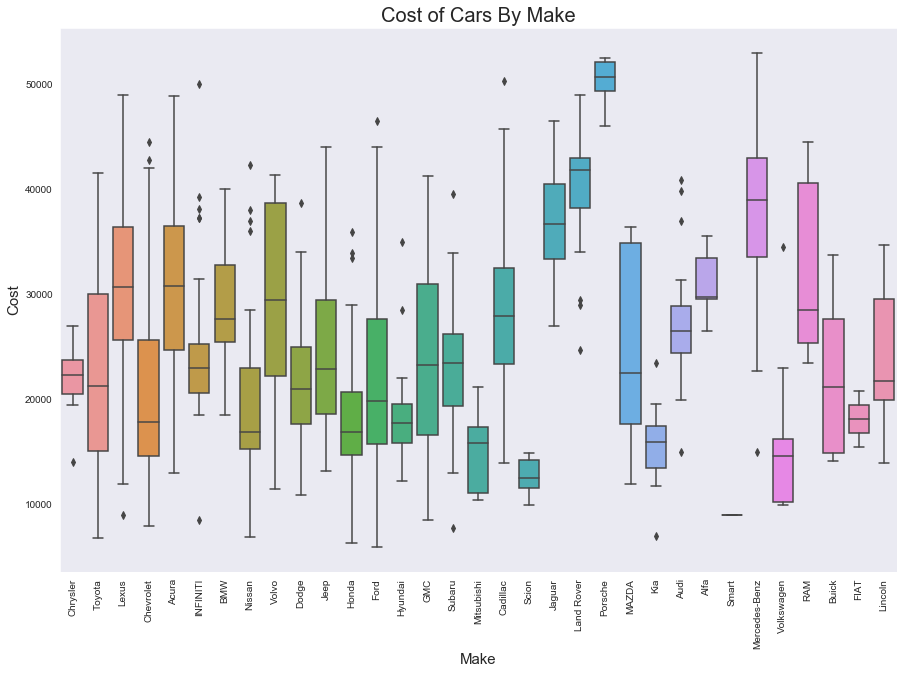

In [128]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='vertical')
plt.title("Cost of Cars By Make", fontsize=20)
plt.xlabel("Make", fontsize=15)
plt.ylabel("Cost", fontsize=15)
sns.set_style("dark")
sns.boxplot(x='Make',y='Cost',data=used_car_values_df)

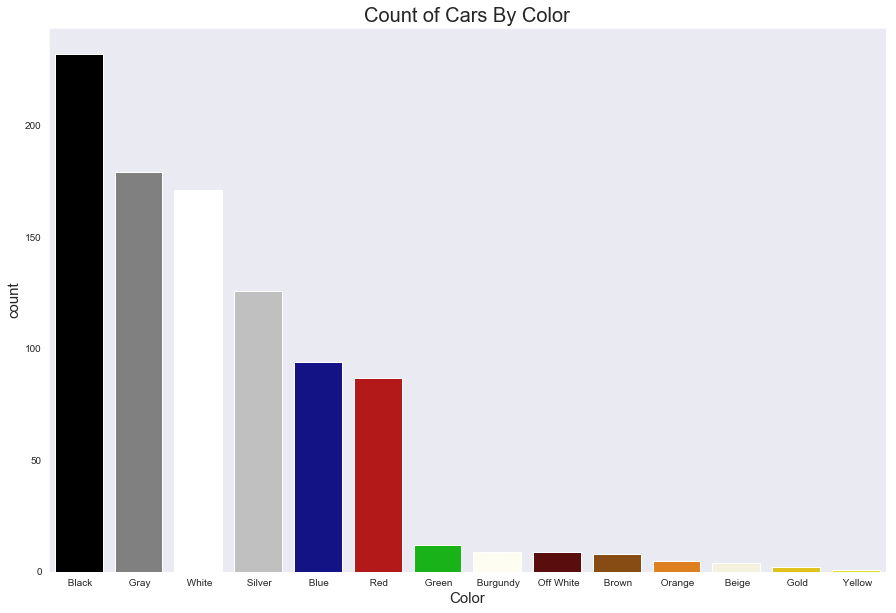

In [129]:
plt.figure(figsize=(15,10))
plt.title("Count of Cars By Color", fontsize=20)
plt.xlabel("Color", fontsize=15)
plt.ylabel("Count", fontsize=15)
sns.set_style("dark")
sns.countplot(x='Color',data=used_car_values_df, order = used_car_values_df['Color'].value_counts().index,
              palette=["#000000", "#808080", '#FFFFFF','#C0C0C0', '#000099', '#CC0000', '#00CC00', '#FFFFF0',
                      '#660000', '#994C00', '#FF8000', '#F5F5DC', '#FFD700', '#FFFF00'])

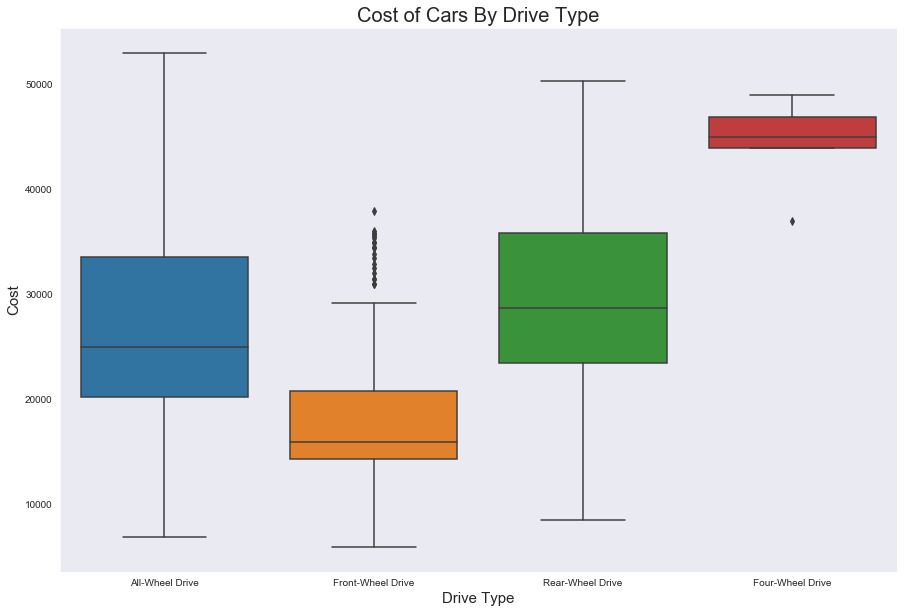

In [130]:
plt.figure(figsize=(15,10))
plt.title("Cost of Cars By Drive Type", fontsize=20)
plt.xlabel("Drive Type", fontsize=15)
plt.ylabel("Cost", fontsize=15)
sns.boxplot(x='Drive Type',y='Cost',data=used_car_values_df)

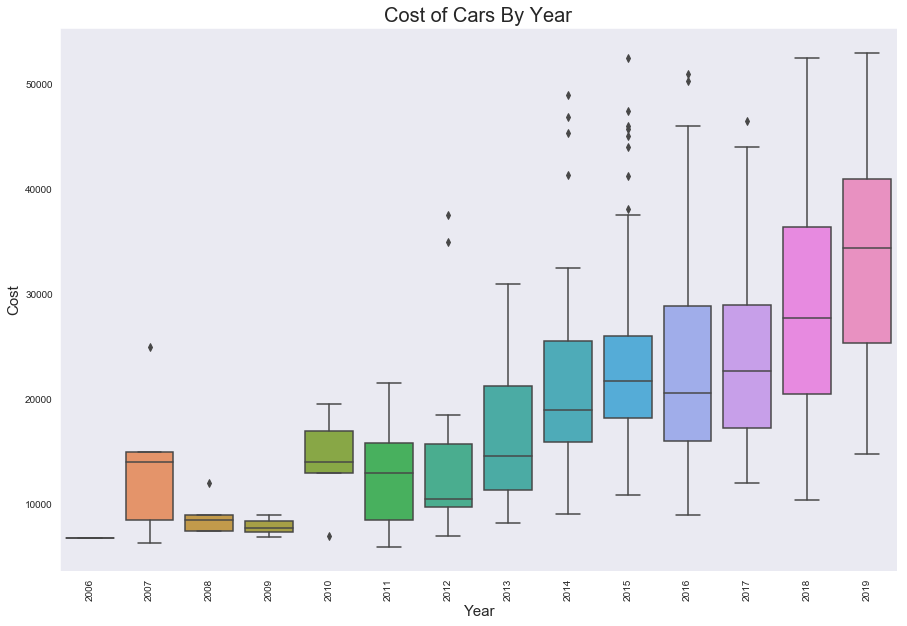

In [131]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='vertical')
plt.title("Cost of Cars By Year", fontsize=20)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Cost", fontsize=15)
sns.boxplot(x='Year',y='Cost',data=used_car_values_df)

# Adding New Categorical Features

In [132]:
def is_luxury(row):
    luxury_brands = ['Lexus', 'Porsche', 'Mercedes-Benz', 'Audi', 'Jaguar', 'INFINITI', 'Land Rover', 'Acura', 'Cadillac', 'Volvo', 'BMW', 'Genesis', 'Lincoln']
    if row['Make'] in luxury_brands:
        return 2
    else:
        return 1

used_car_values_df['Luxury'] = used_car_values_df.apply(is_luxury, axis=1)
used_car_values_df.head(15)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,MPG City,MPG Highway,Age,Certified,Engine Cylinders,Luxury
0,Certified,2017,Chrysler,300,S AWD,22500,29946.0,Gray,All-Wheel Drive,18,27,3,2,6,1
1,Used,2018,Toyota,Corolla,LE,12907,49465.0,Gray,Front-Wheel Drive,28,36,2,1,4,1
2,Used,2018,Lexus,NX,300 AWD,35972,9188.0,Silver,All-Wheel Drive,22,28,2,1,4,2
3,Used,2017,Chevrolet,Cruze,LT Sedan,13150,16748.0,White,Front-Wheel Drive,30,40,3,1,4,1
4,Used,2014,Acura,RDX,AWD w/ Technology Package,18500,47688.0,Silver,All-Wheel Drive,19,27,6,1,6,2
5,Certified,2015,INFINITI,Q50,Premium,19805,36949.0,White,All-Wheel Drive,19,27,5,2,6,2
6,Used,2018,BMW,430i,Convertible,26999,41802.0,White,Rear-Wheel Drive,24,34,2,1,4,2
7,Certified,2015,INFINITI,Q50,Premium,20204,37282.0,Gray,All-Wheel Drive,19,27,5,2,6,2
8,Certified,2015,INFINITI,Q50,Premium,20441,32733.0,Gray,All-Wheel Drive,19,27,5,2,6,2
9,Certified,2015,INFINITI,Q50,Premium,20480,36866.0,White,All-Wheel Drive,19,27,5,2,6,2


In [133]:
used_car_values_df['Color'].value_counts()

 Black        232
 Gray         179
 White        171
 Silver       126
 Blue          94
 Red           87
 Green         12
 Burgundy       9
 Off White      9
 Brown          8
 Orange         5
 Beige          4
 Gold           2
 Yellow         1
Name: Color, dtype: int64

In [134]:
def is_popular_color(row):
    unpopular_colors = [' Burgundy', ' Brown', ' Off White', ' Green', ' Beige', ' Orange', ' Tan', ' Gold', 'Yellow']
    standard_colors = [' Blue', ' Red']
    if row['Color'] in unpopular_colors:
        return 0
    elif row['Color'] in standard_colors:
        return 1
    else:
        return 2

used_car_values_df['Popular Color'] = used_car_values_df.apply(is_popular_color, axis=1)
used_car_values_df.head(15)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,MPG City,MPG Highway,Age,Certified,Engine Cylinders,Luxury,Popular Color
0,Certified,2017,Chrysler,300,S AWD,22500,29946.0,Gray,All-Wheel Drive,18,27,3,2,6,1,2
1,Used,2018,Toyota,Corolla,LE,12907,49465.0,Gray,Front-Wheel Drive,28,36,2,1,4,1,2
2,Used,2018,Lexus,NX,300 AWD,35972,9188.0,Silver,All-Wheel Drive,22,28,2,1,4,2,2
3,Used,2017,Chevrolet,Cruze,LT Sedan,13150,16748.0,White,Front-Wheel Drive,30,40,3,1,4,1,2
4,Used,2014,Acura,RDX,AWD w/ Technology Package,18500,47688.0,Silver,All-Wheel Drive,19,27,6,1,6,2,2
5,Certified,2015,INFINITI,Q50,Premium,19805,36949.0,White,All-Wheel Drive,19,27,5,2,6,2,2
6,Used,2018,BMW,430i,Convertible,26999,41802.0,White,Rear-Wheel Drive,24,34,2,1,4,2,2
7,Certified,2015,INFINITI,Q50,Premium,20204,37282.0,Gray,All-Wheel Drive,19,27,5,2,6,2,2
8,Certified,2015,INFINITI,Q50,Premium,20441,32733.0,Gray,All-Wheel Drive,19,27,5,2,6,2,2
9,Certified,2015,INFINITI,Q50,Premium,20480,36866.0,White,All-Wheel Drive,19,27,5,2,6,2,2


In [135]:
def is_foreign(row):
    domestic_brands = ['Buick', 'Cadillac', 'Chevrolet', 'GMC', 'Chrysler', 'Dodge', 'Jeep', 'RAM', 'Ford']
    if row['Make'] in domestic_brands:
        return 1
    else:
        return 2

used_car_values_df['Foreign'] = used_car_values_df.apply(is_foreign, axis=1)
used_car_values_df.head(15)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,Drive Type,MPG City,MPG Highway,Age,Certified,Engine Cylinders,Luxury,Popular Color,Foreign
0,Certified,2017,Chrysler,300,S AWD,22500,29946.0,Gray,All-Wheel Drive,18,27,3,2,6,1,2,1
1,Used,2018,Toyota,Corolla,LE,12907,49465.0,Gray,Front-Wheel Drive,28,36,2,1,4,1,2,2
2,Used,2018,Lexus,NX,300 AWD,35972,9188.0,Silver,All-Wheel Drive,22,28,2,1,4,2,2,2
3,Used,2017,Chevrolet,Cruze,LT Sedan,13150,16748.0,White,Front-Wheel Drive,30,40,3,1,4,1,2,1
4,Used,2014,Acura,RDX,AWD w/ Technology Package,18500,47688.0,Silver,All-Wheel Drive,19,27,6,1,6,2,2,2
5,Certified,2015,INFINITI,Q50,Premium,19805,36949.0,White,All-Wheel Drive,19,27,5,2,6,2,2,2
6,Used,2018,BMW,430i,Convertible,26999,41802.0,White,Rear-Wheel Drive,24,34,2,1,4,2,2,2
7,Certified,2015,INFINITI,Q50,Premium,20204,37282.0,Gray,All-Wheel Drive,19,27,5,2,6,2,2,2
8,Certified,2015,INFINITI,Q50,Premium,20441,32733.0,Gray,All-Wheel Drive,19,27,5,2,6,2,2,2
9,Certified,2015,INFINITI,Q50,Premium,20480,36866.0,White,All-Wheel Drive,19,27,5,2,6,2,2,2


In [136]:
used_car_values_df = pd.get_dummies(used_car_values_df, columns=['Drive Type'])
used_car_values_df.head(5)

,Status,Year,Make,Model,Trim Level,Cost,Miles,Color,MPG City,MPG Highway,Age,Certified,Engine Cylinders,Luxury,Popular Color,Foreign,Drive Type_All-Wheel Drive,Drive Type_Four-Wheel Drive,Drive Type_Front-Wheel Drive,Drive Type_Rear-Wheel Drive
0,Certified,2017,Chrysler,300,S AWD,22500,29946.0,Gray,18,27,3,2,6,1,2,1,1,0,0,0
1,Used,2018,Toyota,Corolla,LE,12907,49465.0,Gray,28,36,2,1,4,1,2,2,0,0,1,0
2,Used,2018,Lexus,NX,300 AWD,35972,9188.0,Silver,22,28,2,1,4,2,2,2,1,0,0,0
3,Used,2017,Chevrolet,Cruze,LT Sedan,13150,16748.0,White,30,40,3,1,4,1,2,1,0,0,1,0
4,Used,2014,Acura,RDX,AWD w/ Technology Package,18500,47688.0,Silver,19,27,6,1,6,2,2,2,1,0,0,0


In [137]:
used_car_values_df = pd.get_dummies(used_car_values_df, columns=['Make'])
used_car_values_df.head(5)

,Status,Year,Model,Trim Level,Cost,Miles,Color,MPG City,MPG Highway,Age,...,Make_Mitsubishi,Make_Nissan,Make_Porsche,Make_RAM,Make_Scion,Make_Smart,Make_Subaru,Make_Toyota,Make_Volkswagen,Make_Volvo
0,Certified,2017,300,S AWD,22500,29946.0,Gray,18,27,3,...,0,0,0,0,0,0,0,0,0,0
1,Used,2018,Corolla,LE,12907,49465.0,Gray,28,36,2,...,0,0,0,0,0,0,0,1,0,0
2,Used,2018,NX,300 AWD,35972,9188.0,Silver,22,28,2,...,0,0,0,0,0,0,0,0,0,0
3,Used,2017,Cruze,LT Sedan,13150,16748.0,White,30,40,3,...,0,0,0,0,0,0,0,0,0,0
4,Used,2014,RDX,AWD w/ Technology Package,18500,47688.0,Silver,19,27,6,...,0,0,0,0,0,0,0,0,0,0


# Regression Analysis

## Pair Plots and Visualizations

/Users/hdeva/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


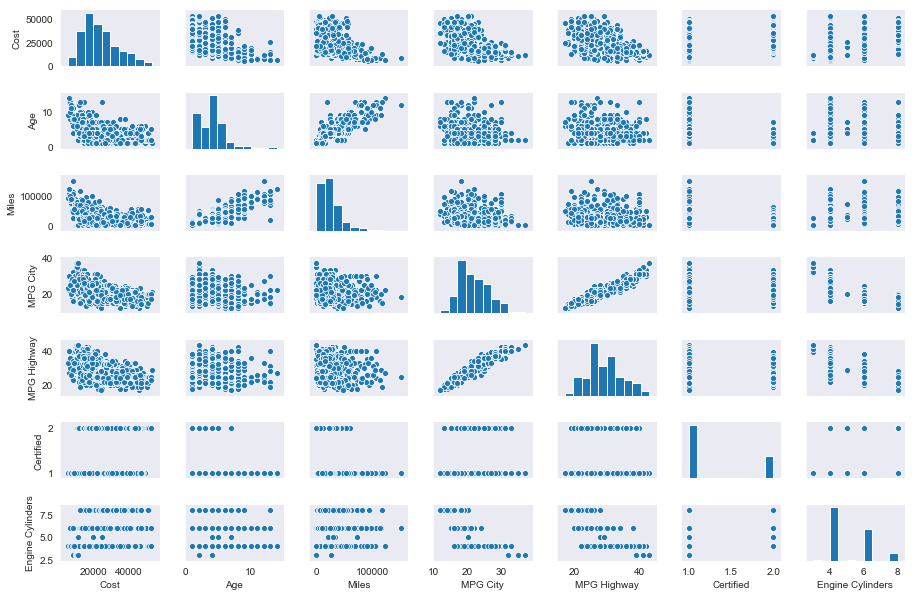

In [138]:

sns.pairplot(used_car_values_df[['Cost', 'Age', 'Miles', 'MPG City', 'MPG Highway', 'Certified', 'Engine Cylinders']], height=1.2, aspect=1.5);

Text(0.5, 1.0, 'Distplot of Cost')

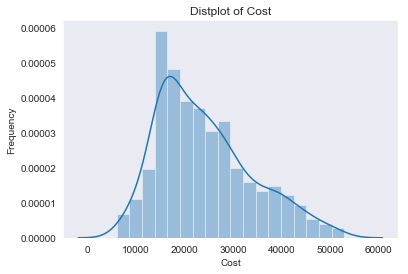

In [139]:
sns.distplot(used_car_values_df['Cost'])
plt.ylabel("Frequency")
plt.title("Distplot of Cost")

Cost, Age, and Miles have positive skewness. We should log transform this data.

In [140]:
used_car_values_df['LogCost'] = np.log(used_car_values_df['Cost'])
used_car_values_df['LogMiles'] = np.log(used_car_values_df['Miles'])
used_car_values_df['LogAge'] = np.log(used_car_values_df['Age'])
used_car_values_df.head(5)

,Status,Year,Model,Trim Level,Cost,Miles,Color,MPG City,MPG Highway,Age,...,Make_RAM,Make_Scion,Make_Smart,Make_Subaru,Make_Toyota,Make_Volkswagen,Make_Volvo,LogCost,LogMiles,LogAge
0,Certified,2017,300,S AWD,22500,29946.0,Gray,18,27,3,...,0,0,0,0,0,0,0,10.021271,10.307151,1.098612
1,Used,2018,Corolla,LE,12907,49465.0,Gray,28,36,2,...,0,0,0,0,1,0,0,9.465525,10.809021,0.693147
2,Used,2018,NX,300 AWD,35972,9188.0,Silver,22,28,2,...,0,0,0,0,0,0,0,10.490496,9.125654,0.693147
3,Used,2017,Cruze,LT Sedan,13150,16748.0,White,30,40,3,...,0,0,0,0,0,0,0,9.484177,9.726034,1.098612
4,Used,2014,RDX,AWD w/ Technology Package,18500,47688.0,Silver,19,27,6,...,0,0,0,0,0,0,0,9.825526,10.772435,1.791759


Text(0.5, 1.0, 'Distplot of LogCost')

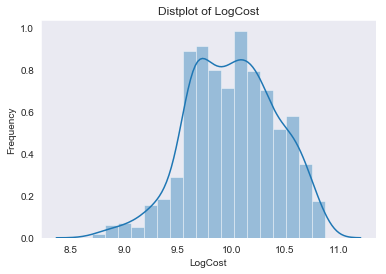

In [141]:
sns.distplot(used_car_values_df['LogCost'])
plt.ylabel("Frequency")
plt.title("Distplot of LogCost")

In [142]:
used_car_values_df[used_car_values_df.isnull().any(axis=1)]

,Status,Year,Model,Trim Level,Cost,Miles,Color,MPG City,MPG Highway,Age,...,Make_RAM,Make_Scion,Make_Smart,Make_Subaru,Make_Toyota,Make_Volkswagen,Make_Volvo,LogCost,LogMiles,LogAge
154,Certified,2019,C,300 4MATIC Sedan,41554,NaN,Black,22,33,1,...,0,0,0,0,0,0,0,10.634749,NaN,0.0


In [143]:
used_car_values_df = used_car_values_df.dropna()
used_car_values_df.shape

(938, 55)

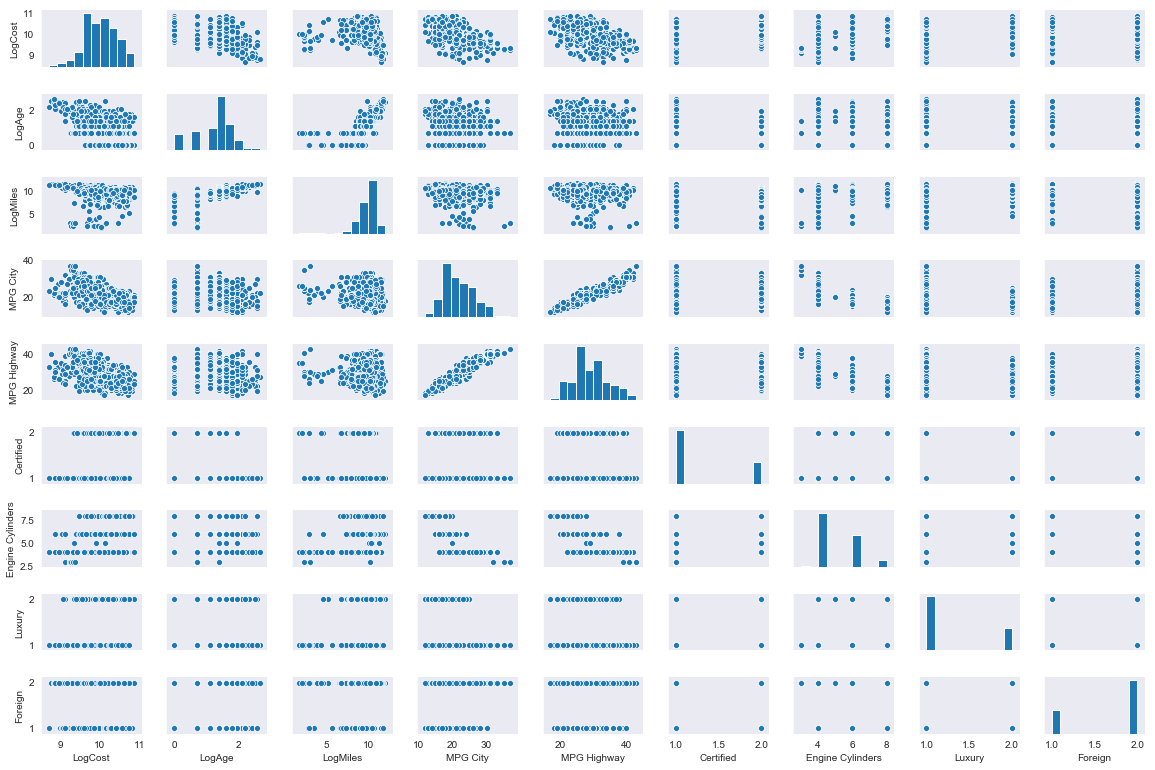

In [144]:
sns.pairplot(used_car_values_df[['LogCost', 'LogAge', 'LogMiles', 'MPG City', 'MPG Highway', 'Certified', 'Engine Cylinders', 'Luxury', 'Foreign']], height=1.2, aspect=1.5);

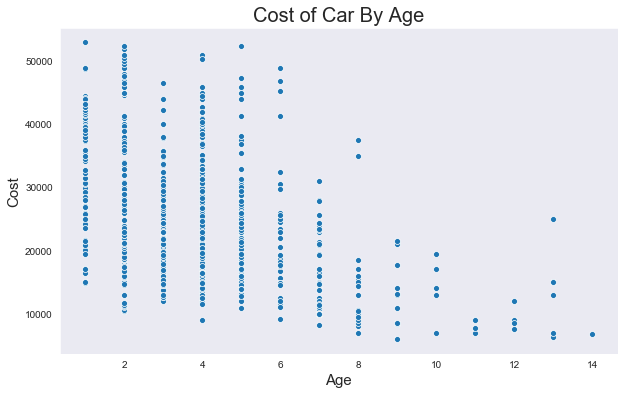

In [145]:
plt.figure(figsize=(10,6))
plt.title("Cost of Car By Age", fontsize=20)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Cost", fontsize=15)
sns.scatterplot(x='Age',y='Cost',data=used_car_values_df)

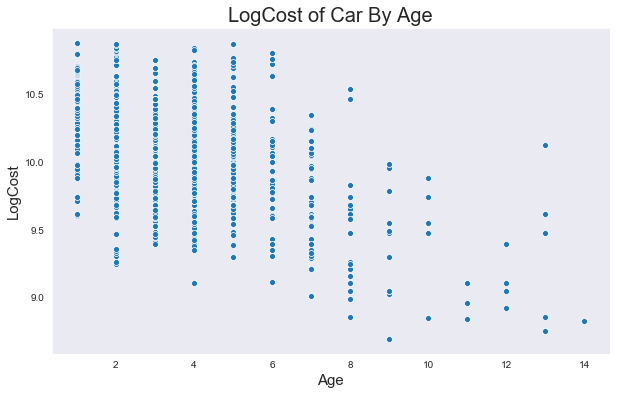

In [146]:
plt.figure(figsize=(10,6))
plt.title("LogCost of Car By Age", fontsize=20)
plt.xlabel("Age", fontsize=15)
plt.ylabel("LogCost", fontsize=15)
sns.scatterplot(x='Age',y='LogCost',data=used_car_values_df)

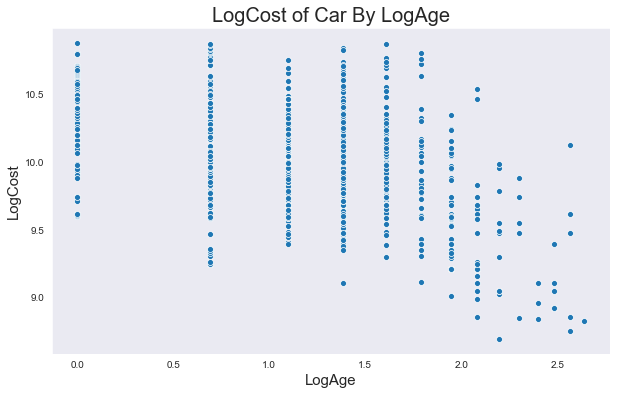

In [147]:
plt.figure(figsize=(10,6))
plt.title("LogCost of Car By LogAge", fontsize=20)
plt.xlabel("LogAge", fontsize=15)
plt.ylabel("LogCost", fontsize=15)
sns.scatterplot(x='LogAge',y='LogCost',data=used_car_values_df)

Because we're doing LogCost, LogAge doesn't seem to show a good relationship as compared to Age. 

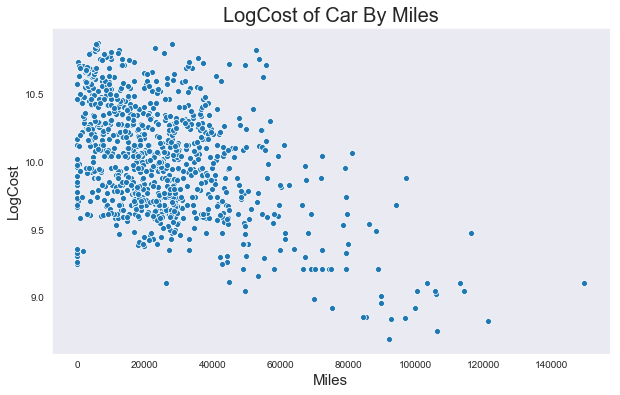

In [148]:
plt.figure(figsize=(10,6))
plt.title("LogCost of Car By Miles", fontsize=20)
plt.xlabel("Miles", fontsize=15)
plt.ylabel("LogCost", fontsize=15)
sns.scatterplot(x='Miles',y='LogCost',data=used_car_values_df)

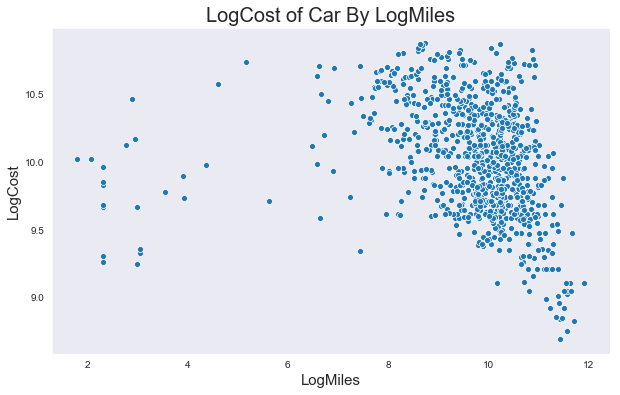

In [149]:
plt.figure(figsize=(10,6))
plt.title("LogCost of Car By LogMiles", fontsize=20)
plt.xlabel("LogMiles", fontsize=15)
plt.ylabel("LogCost", fontsize=15)
sns.scatterplot(x='LogMiles',y='LogCost',data=used_car_values_df)

Because we're doing LogCost, LogMiles doesn't seem to show a good relationship as compared to Miles.

Text(0.5, 1.0, 'LogAge Histogram')

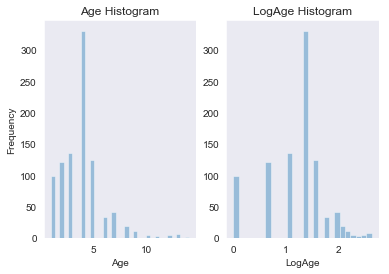

In [150]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.distplot(used_car_values_df['Age'], kde=False, ax=ax1)
sns.distplot(used_car_values_df['LogAge'], kde=False, ax=ax2)
ax1.set_ylabel("Frequency")
ax1.set_title("Age Histogram")
ax2.set_title("LogAge Histogram")

Text(0.5, 1.0, 'LogCost Histogram')

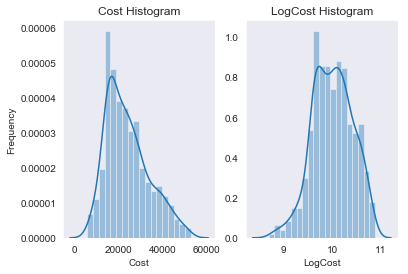

In [151]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.distplot(used_car_values_df['Cost'], ax=ax1)
sns.distplot(used_car_values_df['LogCost'], ax=ax2)
ax1.set_ylabel("Frequency")
ax1.set_title("Cost Histogram")
ax2.set_title("LogCost Histogram")

Text(0.5, 1.0, 'LogMiles Histogram')

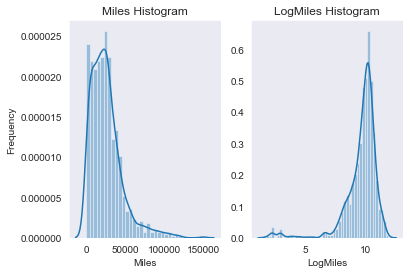

In [152]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.distplot(used_car_values_df['Miles'], ax=ax1)
sns.distplot(used_car_values_df['LogMiles'], ax=ax2)
ax1.set_ylabel("Frequency")
ax1.set_title("Miles Histogram")
ax2.set_title("LogMiles Histogram")

Hard to tell if log transforming Age and Miles make a significant impact.

## Adding Interaction Terms for Features

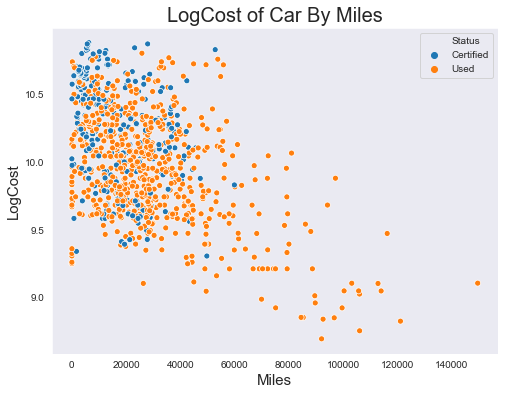

In [153]:
plt.figure(figsize=(8,6))
plt.title("LogCost of Car By Miles", fontsize=20)
plt.xlabel("Miles", fontsize=15)
plt.ylabel("LogCost", fontsize=15)
sns.scatterplot(x='Miles',y='LogCost',data=used_car_values_df, hue='Status')

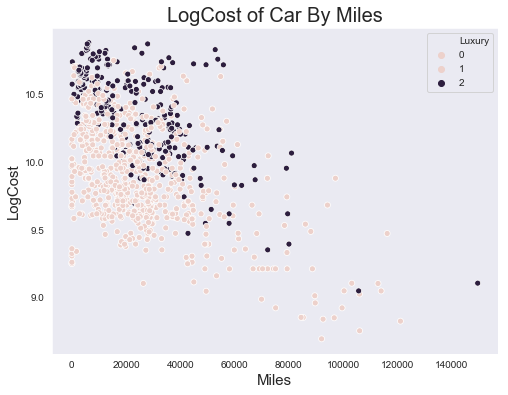

In [154]:
plt.figure(figsize=(8,6))
plt.title("LogCost of Car By Miles", fontsize=20)
plt.xlabel("Miles", fontsize=15)
plt.ylabel("LogCost", fontsize=15)
sns.scatterplot(x='Miles',y='LogCost',data=used_car_values_df, hue='Luxury')

In [155]:
used_car_values_df['Certified x Luxury'] = used_car_values_df['Certified'] * used_car_values_df['Luxury']
used_car_values_df.head(5)

,Status,Year,Model,Trim Level,Cost,Miles,Color,MPG City,MPG Highway,Age,...,Make_Scion,Make_Smart,Make_Subaru,Make_Toyota,Make_Volkswagen,Make_Volvo,LogCost,LogMiles,LogAge,Certified x Luxury
0,Certified,2017,300,S AWD,22500,29946.0,Gray,18,27,3,...,0,0,0,0,0,0,10.021271,10.307151,1.098612,2
1,Used,2018,Corolla,LE,12907,49465.0,Gray,28,36,2,...,0,0,0,1,0,0,9.465525,10.809021,0.693147,1
2,Used,2018,NX,300 AWD,35972,9188.0,Silver,22,28,2,...,0,0,0,0,0,0,10.490496,9.125654,0.693147,2
3,Used,2017,Cruze,LT Sedan,13150,16748.0,White,30,40,3,...,0,0,0,0,0,0,9.484177,9.726034,1.098612,1
4,Used,2014,RDX,AWD w/ Technology Package,18500,47688.0,Silver,19,27,6,...,0,0,0,0,0,0,9.825526,10.772435,1.791759,2


Text(0.5, 1.0, 'Age vs Miles')

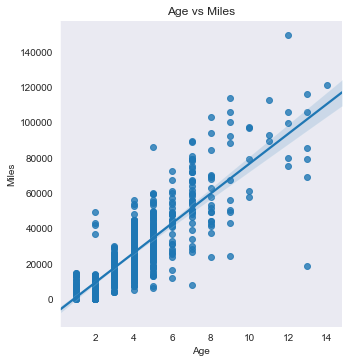

In [156]:
sns.lmplot(x='Age',y='Miles',data=used_car_values_df)
plt.title("Age vs Miles")

In [157]:
used_car_values_df['Age x Miles'] = used_car_values_df['Age'] * used_car_values_df['Miles']
used_car_values_df.head(5)

,Status,Year,Model,Trim Level,Cost,Miles,Color,MPG City,MPG Highway,Age,...,Make_Smart,Make_Subaru,Make_Toyota,Make_Volkswagen,Make_Volvo,LogCost,LogMiles,LogAge,Certified x Luxury,Age x Miles
0,Certified,2017,300,S AWD,22500,29946.0,Gray,18,27,3,...,0,0,0,0,0,10.021271,10.307151,1.098612,2,89838.0
1,Used,2018,Corolla,LE,12907,49465.0,Gray,28,36,2,...,0,0,1,0,0,9.465525,10.809021,0.693147,1,98930.0
2,Used,2018,NX,300 AWD,35972,9188.0,Silver,22,28,2,...,0,0,0,0,0,10.490496,9.125654,0.693147,2,18376.0
3,Used,2017,Cruze,LT Sedan,13150,16748.0,White,30,40,3,...,0,0,0,0,0,9.484177,9.726034,1.098612,1,50244.0
4,Used,2014,RDX,AWD w/ Technology Package,18500,47688.0,Silver,19,27,6,...,0,0,0,0,0,9.825526,10.772435,1.791759,2,286128.0


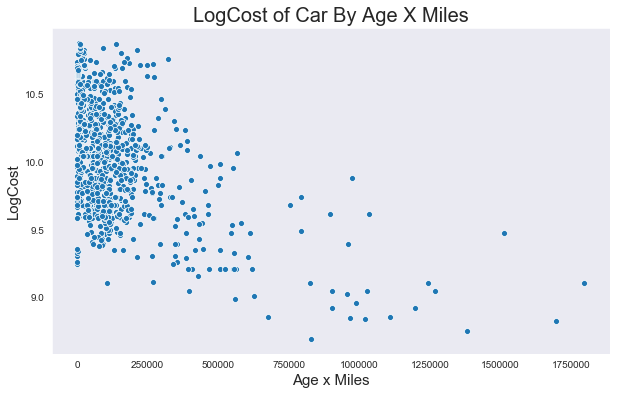

In [158]:
plt.figure(figsize=(10,6))
plt.title("LogCost of Car By Age X Miles", fontsize=20)
plt.xlabel("Age X Miles", fontsize=15)
plt.ylabel("LogCost", fontsize=15)
sns.scatterplot(x='Age x Miles',y='LogCost',data=used_car_values_df)

## Export to Excel (For Tableau)

In [159]:
used_car_values_df = used_car_values_df.reset_index()
used_car_values_df = used_car_values_df.drop(['index'], axis=1)
used_car_values_df.to_excel("used_cars.xlsx") 

## Heatmap

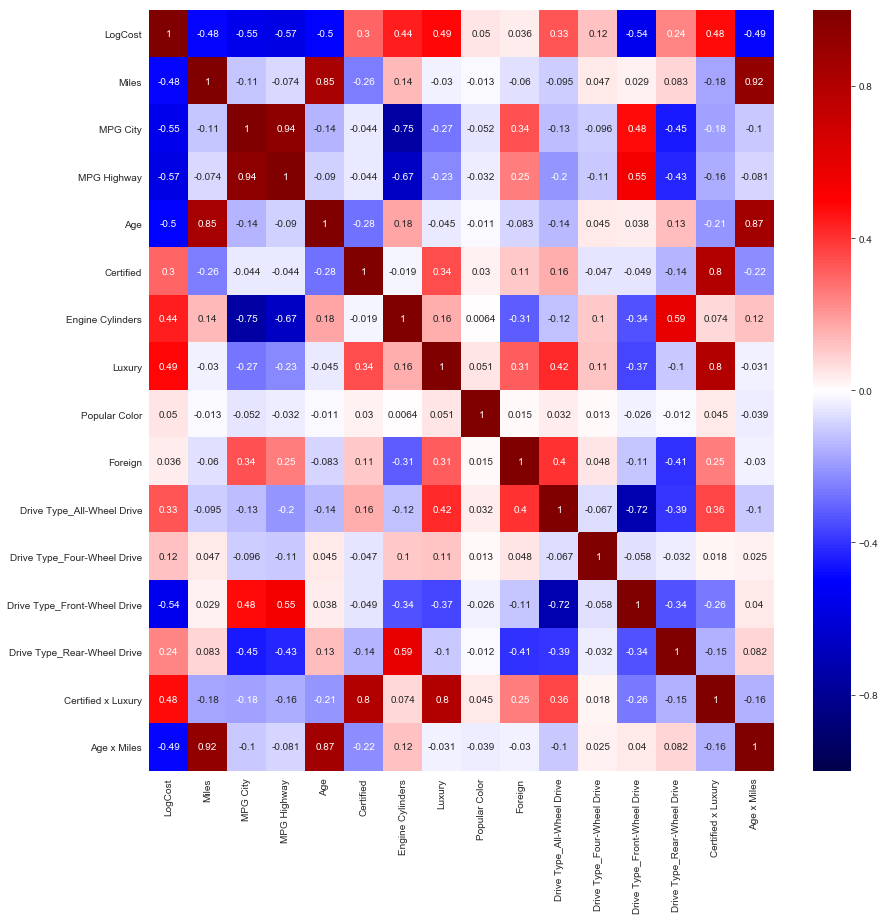

In [160]:
plt.figure(figsize=(14,14))
#sns.heatmap(used_car_values_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
sns.heatmap(used_car_values_df[['LogCost', 'Miles', 'MPG City', 'MPG Highway', 'Age',
                               'Certified', 'Engine Cylinders', 'Luxury', 'Popular Color',
                               'Foreign', 'Drive Type_All-Wheel Drive', 'Drive Type_Four-Wheel Drive',
                               'Drive Type_Front-Wheel Drive', 'Drive Type_Rear-Wheel Drive',
                               'Certified x Luxury', 'Age x Miles']].corr(), 
            cmap="seismic", annot=True, vmin=-1, vmax=1);

MPG City and MPG Highway are closely correlated. To avoid multicollinearity, we need to remove one of those variables. We'll remove MPG City.

Age and Miles also have a strong correlation. Maybe we could remove both and keep Age X Miles.

In [161]:
used_car_values_df.columns

Index(['Status', 'Year', 'Model', 'Trim Level', 'Cost', 'Miles', 'Color',
       'MPG City', 'MPG Highway', 'Age', 'Certified', 'Engine Cylinders',
       'Luxury', 'Popular Color', 'Foreign', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_FIAT', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz', 'Make_Mitsubishi',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion', 'Make_Smart',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo',
       'LogCost', 'LogMiles', 'LogAge', 'Certified x Luxury', 'Age x Miles'],
      dtype='object')

## First Linear Model - Baseline (Use LogAge and LogMiles, Include All Values)

In [162]:
#Split for Multiple Linear Regression
X = used_car_values_df[['MPG Highway',
       'Certified', 'Engine Cylinders', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'LogMiles', 'LogAge', 'Luxury',
        'Foreign', 'Popular Color', 'Certified x Luxury', 'Age x Miles',
        'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_FIAT', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz', 'Make_Mitsubishi',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion', 'Make_Smart',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo']]
y = used_car_values_df[['LogCost']]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LogCost   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     109.8
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          3.54e-281
Time:                        15:07:54   Log-Likelihood:                 372.21
No. Observations:                 750   AIC:                            -656.4
Df Residuals:                     706   BIC:                            -453.1
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
MPG Highway                     -0.0224      0.002    -12.393      0.000      -0.026      -0.019
Certified                       -0.0619      0.043     -1.440      0.150      -0.146       0.023
Engine Cylinders                 0.0948      0.008     12.424      0.000       0.080       0.110
Drive Type_All-Wheel Drive       3.2735      0.039     84.321      0.000       3.197       3.350
Drive Type_Four-Wheel Drive      3.4612      0.084     41.148      0.000       3.296       3.626
Drive Type_Front-Wheel Drive     3.1967      0.043     75.014      0.000       3.113       3.280
Drive Type_Rear-Wheel Drive      3.3344      0.043     77.409      0.000       3.250       3.419
LogMiles                         0.0015      0.008      0.197      0.844      -0.013       0.016
LogAge                          -0.1634      0.018     -8.850      0.000      -0.200      -0.127
Luxury                           1.5850      0.037     42.522      0.000       1.512       1.658
Foreign                          2.6653      0.033     80.206      0.000       2.600       2.731
Popular Color                    0.0004      0.011      0.034      0.973      -0.021       0.021
Certified x Luxury               0.0769      0.030      2.599      0.010       0.019       0.135
Age x Miles                  -7.735e-07   4.02e-08    -19.240      0.000   -8.52e-07   -6.95e-07
Make_Acura                      -1.3425      0.040    -33.435      0.000      -1.421      -1.264
Make_Alfa                        0.4903      0.061      8.047      0.000       0.371       0.610
Make_Audi                       -1.1907      0.043    -27.613      0.000      -1.275      -1.106
Make_BMW                        -1.1292      0.060    -18.827      0.000      -1.247      -1.011
Make_Buick                       2.9478      0.056     52.391      0.000       2.837       3.058
Make_Cadillac                    1.2973      0.038     34.561      0.000       1.224       1.371
Make_Chevrolet                   2.8173      0.042     67.236      0.000       2.735       2.900
Make_Chrysler                    2.7509      0.057     48.375      0.000       2.639       2.863
Make_Dodge                       2.6876      0.049     55.240      0.000       2.592       2.783
Make_FIAT                        0.1175      0.143      0.821      0.412      -0.164       0.398
Make_Ford                        2.8217      0.039     72.164      0.000       2.745       2.898
Make_GMC                         2.9028      0.049     59.258      0.000       2.807       2.999
Make_Honda                       0.3065      0.027     11.434      0.000       0.254       0.359
Make_Hyundai                     0.1539      0.035      4.344      0.000       0.084       0.223
Make_INFINITI                   -1.5067      0.031    -47.880      0.000    

Text(0, 0.5, 'Residuals')

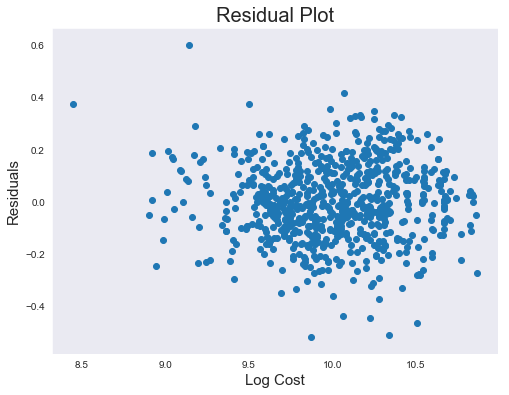

In [163]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(8, 6))
plt.scatter(fit.predict(), fit.resid);
plt.title("Residual Plot", fontsize=20)
plt.xlabel("Log Cost", fontsize=15)
plt.ylabel("Residuals", fontsize=15)

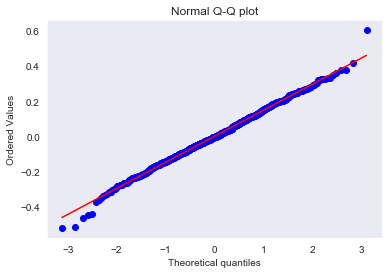

In [164]:
stats.probplot(fit.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

## Second Linear Model (Use LogAge, Remove Variables with high P values - Certified, Popular Color, LogMiles, Make_FIAT, Make_Mitsubishi, Make_Smart)

In [165]:
#Split for Multiple Linear Regression
X = used_car_values_df[['MPG Highway',
       'Engine Cylinders', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'LogAge', 'Luxury',
        'Foreign', 'Age x Miles',
       'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo']]
y = used_car_values_df[['LogCost']]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LogCost   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     124.8
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          2.51e-283
Time:                        15:07:55   Log-Likelihood:                 362.17
No. Observations:                 750   AIC:                            -648.3
Df Residuals:                     712   BIC:                            -472.8
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
MPG Highway                     -0.0226      0.002    -12.431      0.000      -0.026      -0.019
Engine Cylinders                 0.0940      0.008     12.279      0.000       0.079       0.109
Drive Type_All-Wheel Drive       3.2711      0.029    113.528      0.000       3.215       3.328
Drive Type_Four-Wheel Drive      3.3926      0.077     43.906      0.000       3.241       3.544
Drive Type_Front-Wheel Drive     3.1936      0.033     96.773      0.000       3.129       3.258
Drive Type_Rear-Wheel Drive      3.3230      0.035     95.535      0.000       3.255       3.391
LogAge                          -0.1716      0.015    -11.546      0.000      -0.201      -0.142
Luxury                           1.6897      0.039     43.205      0.000       1.613       1.766
Foreign                          2.6369      0.044     60.486      0.000       2.551       2.723
Age x Miles                  -7.735e-07   4.02e-08    -19.250      0.000   -8.52e-07   -6.95e-07
Make_Acura                      -1.2987      0.036    -36.329      0.000      -1.369      -1.229
Make_Alfa                        0.4903      0.075      6.519      0.000       0.343       0.638
Make_Audi                       -1.1831      0.043    -27.625      0.000      -1.267      -1.099
Make_BMW                        -1.1476      0.060    -19.066      0.000      -1.266      -1.029
Make_Buick                       2.9321      0.050     58.910      0.000       2.834       3.030
Make_Cadillac                    1.2897      0.047     27.572      0.000       1.198       1.382
Make_Chevrolet                   2.8030      0.033     84.058      0.000       2.738       2.868
Make_Chrysler                    2.7300      0.051     53.679      0.000       2.630       2.830
Make_Dodge                       2.6719      0.042     63.391      0.000       2.589       2.755
Make_Ford                        2.8016      0.034     82.967      0.000       2.735       2.868
Make_GMC                         2.8871      0.043     67.323      0.000       2.803       2.971
Make_Honda                       0.3150      0.047      6.759      0.000       0.223       0.406
Make_Hyundai                     0.1632      0.052      3.110      0.002       0.060       0.266
Make_INFINITI                   -1.4665      0.029    -50.792      0.000      -1.523      -1.410
Make_Jaguar                     -1.0944      0.061    -18.061      0.000      -1.213      -0.975
Make_Jeep                        2.8668      0.029     97.748      0.000       2.809       2.924
Make_Kia                         0.0846      0.059      1.434      0.152      -0.031       0.201
Make_Land Rover                 -1.0738      0.045    -23.601      0.000      -1.163      -0.984
Make_Lexus                      -1.1715      0.027    -42.663      0.000    

Text(0, 0.5, 'Residuals')

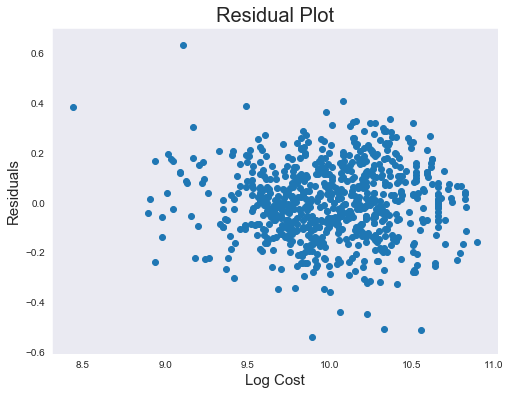

In [166]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(8, 6))
plt.scatter(fit.predict(), fit.resid);
plt.title("Residual Plot", fontsize=20)
plt.xlabel("Log Cost", fontsize=15)
plt.ylabel("Residuals", fontsize=15)

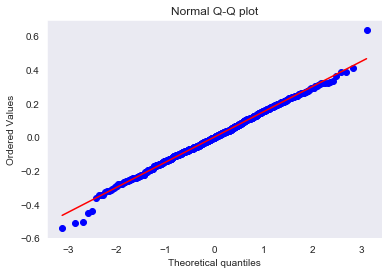

In [167]:
stats.probplot(fit.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

## Third Linear Model (Use Baseline, but Age and Miles instead of LogAge and LogMiles)

In [168]:
#Split for Multiple Linear Regression
X = used_car_values_df[['MPG Highway',
       'Certified', 'Engine Cylinders', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'Miles', 'Age', 'Luxury',
        'Foreign', 'Popular Color', 'Certified x Luxury', 'Age x Miles',
       'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_FIAT', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz', 'Make_Mitsubishi',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion', 'Make_Smart',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo']]
y = used_car_values_df[['LogCost']]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LogCost   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     112.4
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          3.03e-284
Time:                        15:07:55   Log-Likelihood:                 379.78
No. Observations:                 750   AIC:                            -671.6
Df Residuals:                     706   BIC:                            -468.3
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
MPG Highway                     -0.0221      0.002    -12.364      0.000      -0.026      -0.019
Certified                       -0.0742      0.043     -1.743      0.082      -0.158       0.009
Engine Cylinders                 0.0985      0.008     12.999      0.000       0.084       0.113
Drive Type_All-Wheel Drive       3.2878      0.033    100.998      0.000       3.224       3.352
Drive Type_Four-Wheel Drive      3.4623      0.080     43.023      0.000       3.304       3.620
Drive Type_Front-Wheel Drive     3.2103      0.037     87.092      0.000       3.138       3.283
Drive Type_Rear-Wheel Drive      3.3489      0.038     89.176      0.000       3.275       3.423
Miles                        -2.557e-06   7.78e-07     -3.287      0.001   -4.08e-06   -1.03e-06
Age                             -0.0600      0.006    -10.114      0.000      -0.072      -0.048
Luxury                           1.5878      0.036     44.223      0.000       1.517       1.658
Foreign                          2.6707      0.030     89.884      0.000       2.612       2.729
Popular Color                   -0.0004      0.011     -0.042      0.967      -0.021       0.020
Certified x Luxury               0.0838      0.029      2.866      0.004       0.026       0.141
Age x Miles                  -3.023e-07   8.46e-08     -3.573      0.000   -4.68e-07   -1.36e-07
Make_Acura                      -1.3380      0.038    -34.811      0.000      -1.413      -1.263
Make_Alfa                        0.4780      0.060      7.922      0.000       0.360       0.596
Make_Audi                       -1.1939      0.042    -28.324      0.000      -1.277      -1.111
Make_BMW                        -1.1345      0.059    -19.222      0.000      -1.250      -1.019
Make_Buick                       2.9577      0.053     56.112      0.000       2.854       3.061
Make_Cadillac                    1.3037      0.036     35.946      0.000       1.232       1.375
Make_Chevrolet                   2.8290      0.037     76.292      0.000       2.756       2.902
Make_Chrysler                    2.7516      0.053     52.163      0.000       2.648       2.855
Make_Dodge                       2.7044      0.044     61.118      0.000       2.617       2.791
Make_FIAT                        0.1059      0.142      0.748      0.455      -0.172       0.384
Make_Ford                        2.8304      0.036     79.694      0.000       2.761       2.900
Make_GMC                         2.9100      0.045     65.085      0.000       2.822       2.998
Make_Honda                       0.3096      0.026     11.844      0.000       0.258       0.361
Make_Hyundai                     0.1646      0.035      4.707      0.000       0.096       0.233
Make_INFINITI                   -1.5083      0.031    -49.296      0.000    

Text(0, 0.5, 'Residuals')

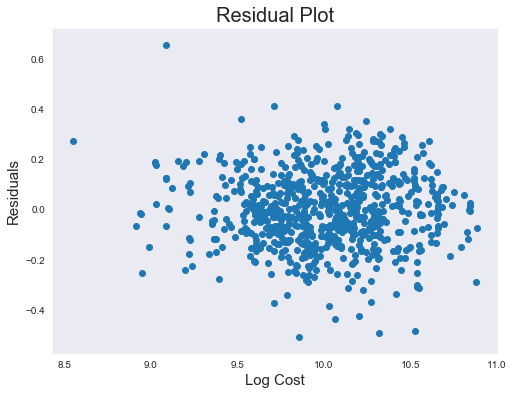

In [169]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(8, 6))
plt.scatter(fit.predict(), fit.resid);
plt.title("Residual Plot", fontsize=20)
plt.xlabel("Log Cost", fontsize=15)
plt.ylabel("Residuals", fontsize=15)

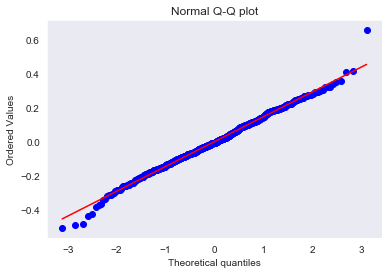

In [170]:
stats.probplot(fit.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

## Fourth Linear Model (Use Model 3, but remove unnecessary variable Foreign and High P values - Popular Color, Make_Fiat, Make_Mitsubishi, Make_Smart)

In [171]:
#Split for Multiple Linear Regression
X = used_car_values_df[['MPG Highway',
       'Certified', 'Engine Cylinders', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'Miles', 'Age', 'Luxury',
       'Certified x Luxury', 'Age x Miles',
       'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo']]
y = used_car_values_df[['LogCost']]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()



# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LogCost   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     120.6
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          1.40e-286
Time:                        15:07:55   Log-Likelihood:                 377.86
No. Observations:                 750   AIC:                            -673.7
Df Residuals:                     709   BIC:                            -484.3
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
MPG Highway                     -0.0223      0.002    -12.470      0.000      -0.026      -0.019
Certified                       -0.0757      0.043     -1.779      0.076      -0.159       0.008
Engine Cylinders                 0.0994      0.008     13.152      0.000       0.085       0.114
Drive Type_All-Wheel Drive       7.5084      0.090     83.495      0.000       7.332       7.685
Drive Type_Four-Wheel Drive      7.6809      0.125     61.262      0.000       7.435       7.927
Drive Type_Front-Wheel Drive     7.4311      0.095     78.562      0.000       7.245       7.617
Drive Type_Rear-Wheel Drive      7.5634      0.094     80.328      0.000       7.379       7.748
Miles                        -2.634e-06   7.76e-07     -3.393      0.001   -4.16e-06   -1.11e-06
Age                             -0.0602      0.006    -10.151      0.000      -0.072      -0.049
Luxury                           2.6948      0.040     67.844      0.000       2.617       2.773
Certified x Luxury               0.0844      0.029      2.886      0.004       0.027       0.142
Age x Miles                  -2.946e-07   8.45e-08     -3.488      0.001    -4.6e-07   -1.29e-07
Make_Acura                      -2.4304      0.047    -51.189      0.000      -2.524      -2.337
Make_Alfa                        0.4952      0.074      6.702      0.000       0.350       0.640
Make_Audi                       -2.2849      0.050    -45.385      0.000      -2.384      -2.186
Make_BMW                        -2.2257      0.065    -34.233      0.000      -2.353      -2.098
Make_Buick                       0.3040      0.063      4.825      0.000       0.180       0.428
Make_Cadillac                   -2.4566      0.049    -50.548      0.000      -2.552      -2.361
Make_Chevrolet                   0.1766      0.048      3.690      0.000       0.083       0.271
Make_Chrysler                    0.0959      0.061      1.582      0.114      -0.023       0.215
Make_Dodge                       0.0513      0.055      0.938      0.349      -0.056       0.159
Make_Ford                        0.1770      0.050      3.560      0.000       0.079       0.275
Make_GMC                         0.2567      0.057      4.524      0.000       0.145       0.368
Make_Honda                       0.3272      0.046      7.047      0.000       0.236       0.418
Make_Hyundai                     0.1820      0.053      3.450      0.001       0.078       0.286
Make_INFINITI                   -2.6004      0.042    -61.325      0.000      -2.684      -2.517
Make_Jaguar                     -2.2202      0.066    -33.587      0.000      -2.350      -2.090
Make_Jeep                        0.2408      0.049      4.925      0.000       0.145       0.337
Make_Kia                         0.0947      0.059      1.614      0.107    

Text(0, 0.5, 'Residuals')

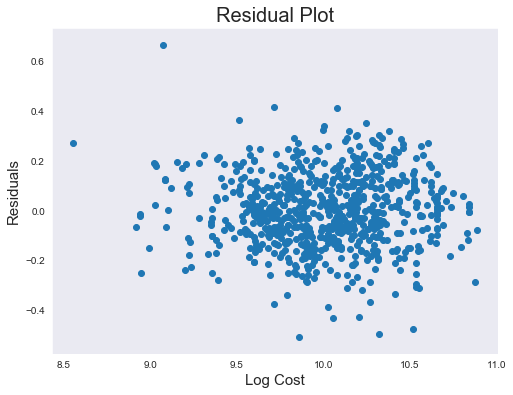

In [172]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(8,6))
plt.scatter(fit.predict(), fit.resid);
plt.title("Residual Plot", fontsize=20)
plt.xlabel("Log Cost", fontsize=15)
plt.ylabel("Residuals", fontsize=15)

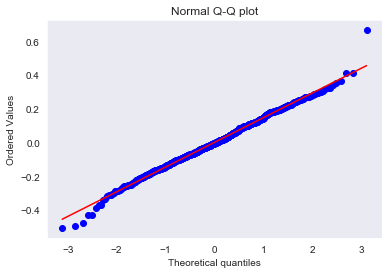

In [173]:
stats.probplot(fit.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

# Cross Validation

In [174]:
def cross_val_score(X, y):
    from sklearn.model_selection import cross_val_score
    # Splitting the dataset into the Cross Validation set and Test set
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

    lm = LinearRegression()

    return cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

## First Linear Model (Use Log Age and Log Miles, Include All Values)

In [175]:
X = used_car_values_df[['MPG Highway',
       'Certified', 'Engine Cylinders', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'LogMiles', 'LogAge', 'Luxury',
        'Foreign', 'Popular Color', 'Certified x Luxury', 'Age x Miles',
        'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_FIAT', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz', 'Make_Mitsubishi',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion', 'Make_Smart',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo']]
y = used_car_values_df[['LogCost']]

cv = cross_val_score(X, y)
print(cv)
print(np.mean(cv))

[0.86541606 0.83873549 0.83439079 0.81364002 0.84329396]
0.8390952608400806


## Second Linear Model (Use LogAge and Log Miles, Remove High P Values)

In [176]:
X = used_car_values_df[['MPG Highway',
       'Engine Cylinders', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'LogAge', 'Luxury',
        'Foreign', 'Age x Miles',
       'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo']]
y = used_car_values_df[['LogCost']]

cv = cross_val_score(X, y)
print(cv)
print(np.mean(cv))

[0.87791967 0.83499648 0.83890364 0.81560111 0.84278733]
0.842041646386245


## Third Linear Model (Use Baseline, but Age and Miles instead of LogAge and Log Miles)

In [177]:
X = used_car_values_df[['MPG Highway',
       'Certified', 'Engine Cylinders', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'Miles', 'Age', 'Luxury',
        'Foreign', 'Popular Color', 'Certified x Luxury', 'Age x Miles',
       'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_FIAT', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz', 'Make_Mitsubishi',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion', 'Make_Smart',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo']]
y = used_car_values_df[['LogCost']]

cv = cross_val_score(X, y)
print(cv)
print(np.mean(cv))

[0.87250489 0.83837686 0.83977934 0.81493272 0.84623424]
0.8423656086561199


## Fourth Linear Model (Use Model 3, but remove High P values and Foreign)

In [178]:
X = used_car_values_df[['MPG Highway',
       'Certified', 'Engine Cylinders', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'Miles', 'Age', 'Luxury',
       'Certified x Luxury', 'Age x Miles',
       'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo']]
y = used_car_values_df[['LogCost']]

cv = cross_val_score(X, y)
print(cv)
print(np.mean(cv))

[0.87380729 0.83802241 0.84734556 0.81550616 0.85076244]
0.8450887687173829


# Lasso/Ridge Regression on All Features

In [179]:
used_car_values_df.columns

Index(['Status', 'Year', 'Model', 'Trim Level', 'Cost', 'Miles', 'Color',
       'MPG City', 'MPG Highway', 'Age', 'Certified', 'Engine Cylinders',
       'Luxury', 'Popular Color', 'Foreign', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_FIAT', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz', 'Make_Mitsubishi',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion', 'Make_Smart',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo',
       'LogCost', 'LogMiles', 'LogAge', 'Certified x Luxury', 'Age x Miles'],
      dtype='object')

In [180]:
X = used_car_values_df[['MPG Highway',
       'Engine Cylinders', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive', 'Foreign',
       'Drive Type_Rear-Wheel Drive', 'Miles', 'Age','Luxury', 'Certified', 'Popular Color', 'Certified x Luxury',
        'Age x Miles', 'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_FIAT', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz', 'Make_Mitsubishi',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion', 'Make_Smart',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo']]
y = used_car_values_df[['LogCost']]

In [181]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [182]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X.values)
X_test_scaled = scaler.transform(X_test.values)

## Ridge Regression

In [183]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5, normalize=True)
ridge_model.fit(X_scaled, y)
ridge_model.alpha_

69.0551352016233

In [184]:
ridge_model = Ridge(alpha = 69.0551352016233)
ridge_model.fit(X_scaled, y)

Ridge(alpha=69.0551352016233, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [185]:
print(*sorted(list(zip(X.columns, ridge_model.coef_[0])), key=lambda x: x[1], reverse=True), sep = "\n")

('Engine Cylinders', 0.10870271419470356)
('Make_Mercedes-Benz', 0.048081948384886976)
('Luxury', 0.04190505996523719)
('Certified x Luxury', 0.039231492115472624)
('Make_Porsche', 0.03407493122332658)
('Drive Type_Rear-Wheel Drive', 0.03204675524296758)
('Make_Land Rover', 0.029424926532048475)
('Make_Lexus', 0.023559584201455454)
('Make_MAZDA', 0.020597691616794412)
('Foreign', 0.020294114033036506)
('Make_Alfa', 0.017398359622945912)
('Make_Subaru', 0.016620338509150002)
('Drive Type_Four-Wheel Drive', 0.016350612045014302)
('Make_Jaguar', 0.01329630980853471)
('Make_Volvo', 0.012685424782613109)
('Make_BMW', 0.01223914794025293)
('Drive Type_All-Wheel Drive', 0.010610117379733178)
('Make_Audi', 0.010344764678987272)
('Make_Honda', 0.009936785126771687)
('Make_Buick', 0.0067194641704756185)
('Make_GMC', 0.00491951841209388)
('Make_Jeep', 0.004371640487189112)
('Make_Toyota', 0.0021730956837696393)
('Popular Color', 0.00029578758632272355)
('Certified', -0.0005643118019115261)
('Make

In [186]:
ridge_model.intercept_

array([10.00551399])

In [187]:
print('\nTrain R^2 score was:', ridge_model.score(X_scaled, y))


Train R^2 score was: 0.8690732270130281


In [188]:
print('\nTest R^2 score was:', ridge_model.score(X_test_scaled, y_test))


Test R^2 score was: 0.8964641118765087


In [189]:
adjusted_r_squared = 1 - (1-ridge_model.score(X_test_scaled, y_test))*(len(y_test['LogCost'].values.tolist())-1)/(len(y_test['LogCost'].values.tolist())-X_test_scaled.shape[1]-1)
print('\nManually calculated adjusted R^2 test score was:', adjusted_r_squared)


Manually calculated adjusted R^2 test score was: 0.8617056351493365


In [190]:
y_test_predict = ridge_model.predict(X_test_scaled)
regression_model_rmse = np.sqrt(mean_squared_error(np.exp(y_test_predict), np.exp(y_test)))
print('\nValidation Regression Model RMSE (Cost): \n', regression_model_rmse)


Validation Regression Model RMSE (Cost): 
 3497.0385715229813


Text(0, 0.5, 'Residuals')

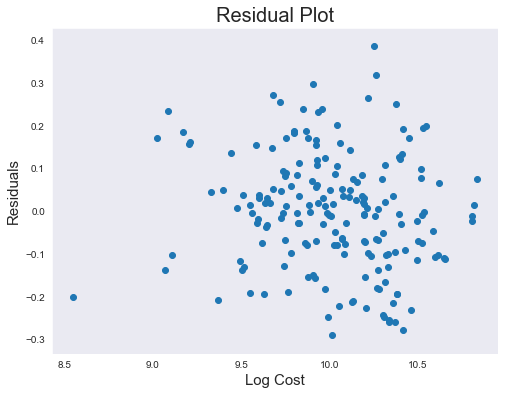

In [191]:
plt.figure(figsize=(8,6))
plt.scatter(y_test_predict.T, y_test_predict.T-np.array(y_test['LogCost']));
plt.title("Residual Plot", fontsize=20)
plt.xlabel("Log Cost", fontsize=15)
plt.ylabel("Residuals", fontsize=15)

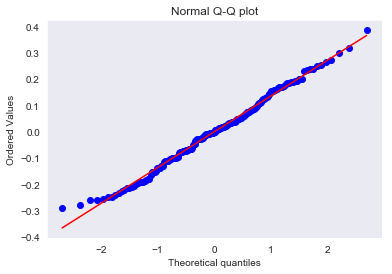

In [192]:
stats.probplot((y_test_predict.T-np.array(y_test['LogCost']))[0], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

## Lasso Regression

In [193]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
lasso_model.alpha_

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.01

In [194]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_scaled, y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [195]:
print(*sorted(list(zip(X.columns, lasso_model.coef_)), key=lambda x: x[1], reverse=True), sep = "\n")

('Engine Cylinders', 0.10743533173615488)
('Luxury', 0.07467073913176545)
('Make_Mercedes-Benz', 0.03442737034642672)
('Make_Porsche', 0.023646847696580507)
('Certified x Luxury', 0.022733848859439736)
('Make_Land Rover', 0.017761464807208818)
('Make_MAZDA', 0.014458203672310294)
('Foreign', 0.013652799141246967)
('Make_Alfa', 0.009135428455136518)
('Make_Subaru', 0.00706733866324007)
('Drive Type_Four-Wheel Drive', 0.006260455788620897)
('Make_Honda', 0.005850716864502483)
('Make_Lexus', 0.0038802934149361726)
('Drive Type_Rear-Wheel Drive', 0.0033935152062635194)
('Make_Jaguar', 0.001997129386749465)
('Drive Type_All-Wheel Drive', 0.0)
('Certified', 0.0)
('Popular Color', 0.0)
('Make_Acura', -0.0)
('Make_Audi', 0.0)
('Make_BMW', 0.0)
('Make_Buick', 0.0)
('Make_Cadillac', -0.0)
('Make_FIAT', -0.0)
('Make_Ford', -0.0)
('Make_GMC', 0.0)
('Make_Jeep', 0.0)
('Make_RAM', -0.0)
('Make_Scion', -0.0)
('Make_Toyota', 0.0)
('Make_Volvo', 0.0)
('Make_Chevrolet', -0.0008427525856949153)
('Make_Vo

In [196]:
lasso_model.intercept_

array([10.00551399])

In [197]:
print('\nTrain R^2 score was:',lasso_model.score(X_scaled, y))


Train R^2 score was: 0.851863797518589


In [198]:
print('\nTest R^2 score was:', lasso_model.score(X_test_scaled, y_test))


Test R^2 score was: 0.8770315300932272


In [199]:
adjusted_r_squared = 1 - (1-lasso_model.score(X_test_scaled, y_test))*(len(y_test['LogCost'].values.tolist())-1)/(len(y_test['LogCost'].values.tolist())-X_test_scaled.shape[1]-1)
print('\nManually calculated adjusted R^2 test score was:', adjusted_r_squared)


Manually calculated adjusted R^2 test score was: 0.8357492580530963


In [200]:
y_test_predict = lasso_model.predict(X_test_scaled)

In [201]:
regression_model_rmse = np.sqrt(mean_squared_error(np.exp(y_test_predict), np.exp(y_test)))
print('\nTest Regression Model RMSE (Cost): \n', regression_model_rmse)


Test Regression Model RMSE (Cost): 
 3911.5555192023126


Text(0, 0.5, 'Residuals')

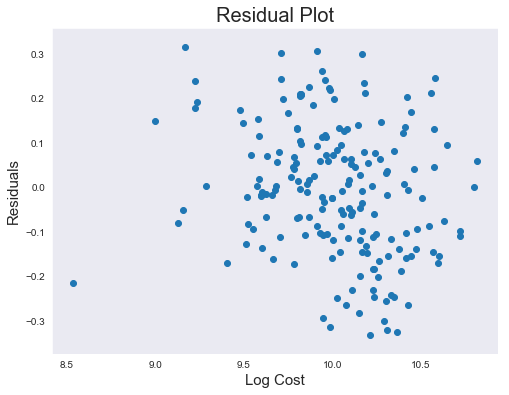

In [202]:
plt.figure(figsize=(8,6))
plt.scatter(y_test_predict.T, y_test_predict.T-np.array(y_test['LogCost']));
plt.title("Residual Plot", fontsize=20)
plt.xlabel("Log Cost", fontsize=15)
plt.ylabel("Residuals", fontsize=15)

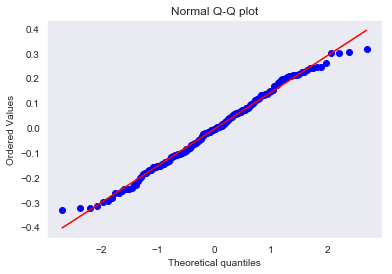

In [203]:
stats.probplot((y_test_predict.T-np.array(y_test['LogCost'])), dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

# Linear Regression Model

In [204]:
def print_linear_model_results(regressor, X, X_test, y, y_test):
   
    rscore = regressor.score(X, y)
    print('\nTrain R^2 score was:', rscore)

    rscore = regressor.score(X_test, y_test)
    print('\nTest R^2 score was:', rscore)

    y_predict = regressor.predict(X_test)

    adjusted_r_squared = 1 - (1-rscore)*(len(y_test['LogCost'].values.tolist())-1)/(len(y_test['LogCost'].values.tolist())-X_test.shape[1]-1)

    print('\nManually calculated adjusted R^2 test score was:', adjusted_r_squared)
    
    regression_model_rmse = np.sqrt(mean_squared_error(np.exp(y_predict), np.exp(y_test)))

    print('\nRegression Model RMSE (Cost): \n', regression_model_rmse)
    
    print('\nIntercept: \n', regressor.intercept_)
    print('Coefficients: \n')
    print(*sorted(list(zip(X.columns, regressor.coef_[0])), key=lambda x: x[1], reverse=True), sep = "\n")

## Use Linear Model 4, as that was the best from cross validation

In [205]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()

X = used_car_values_df[['MPG Highway',
       'Certified', 'Engine Cylinders', 'Drive Type_All-Wheel Drive',
       'Drive Type_Four-Wheel Drive', 'Drive Type_Front-Wheel Drive',
       'Drive Type_Rear-Wheel Drive', 'Miles', 'Age', 'Luxury',
       'Certified x Luxury', 'Age x Miles',
       'Make_Acura', 'Make_Alfa', 'Make_Audi',
       'Make_BMW', 'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet',
       'Make_Chrysler', 'Make_Dodge', 'Make_Ford', 'Make_GMC',
       'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar',
       'Make_Jeep', 'Make_Kia', 'Make_Land Rover', 'Make_Lexus',
       'Make_Lincoln', 'Make_MAZDA', 'Make_Mercedes-Benz',
       'Make_Nissan', 'Make_Porsche', 'Make_RAM', 'Make_Scion',
       'Make_Subaru', 'Make_Toyota', 'Make_Volkswagen', 'Make_Volvo']]
y = used_car_values_df[['LogCost']]

    
# Splitting the dataset into the Training/Validation set and Test set
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
       
#Fitting Multiple Linear Regression to the Training/Validation Set
regressor.fit(X, y)    

print_linear_model_results(regressor, X, X_test, y, y_test)



Train R^2 score was: 0.8718476038500782

Test R^2 score was: 0.8984248151492026

Manually calculated adjusted R^2 test score was: 0.869003037468282

Regression Model RMSE (Cost): 
 3465.8809828338494

Intercept: 
 [9.86778032]
Coefficients: 

('Make_Alfa', 0.4951912507035311)
('Make_MAZDA', 0.44555461350015735)
('Make_Porsche', 0.37969857517921984)
('Luxury', 0.3729223240825359)
('Make_Subaru', 0.35928239321650673)
('Make_Honda', 0.3271518356236998)
('Make_Buick', 0.30396441272809843)
('Make_Toyota', 0.28641126495790126)
('Make_GMC', 0.2567217893687772)
('Make_Jeep', 0.24084803026987525)
('Make_Volkswagen', 0.21667598752547312)
('Make_Hyundai', 0.18201328042274514)
('Make_Ford', 0.17703868734957898)
('Make_Chevrolet', 0.17660668354136375)
('Make_Mercedes-Benz', 0.17254426074914667)
('Make_Nissan', 0.16751633165369484)
('Make_Scion', 0.16666354653713816)
('Drive Type_Four-Wheel Drive', 0.13499059384742856)
('Make_Land Rover', 0.12447917097277908)
('Make_RAM', 0.1159064469417113)
('Make

# Conclusion

The 4th linear model had the highest r^2, and lowest RMSE out of the ridge model, lasso model, and all other linear models. 

Below is a cost prediction of a 2015 Burgundy Lexus RC 340 AWD, with 55,000 miles, 26 MPG, All wheel drive, and 6 cylinders. 

In [206]:
friend_car = [[26, 1, 6, 1, 0, 0, 0, 55000.0, 5, 2, 2, 275000, 
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
friend_car_predict = regressor.predict(friend_car)
print('\nCost Prediction: \n', np.exp(friend_car_predict))


Cost Prediction: 
 [[26902.53622792]]
